# <center><span style="font-size:100px ; color:red">Projet 09:</span> </center>

##  <center><span style="font-size:50px ; color:"> Produisez une étude de marché avec <span style="font-size:50px ; color:red">R</span> ou <span style="font-size:50px ; color:red">Python</span></center>

####  <span style="font-size:40px ; color:blue">Partie 1:</span> <span style="font-size:30px">Clusterings et visualisations</span>

# Sommaire:
1. [Importation des librairies](#1.-Importation-des-librairies)  
2. [Importation et Préparation des données](#2.-Importation-et-Préparation-des-données)  
    2.1. [Importation](#2.1.-Importation)  
    2.2. [Prépration](#2.2.-Préparation)  
    2.3. [Standardisation des données](#2.3.-Standardisation-des-données)  
3. [ACP](#3.-ACP)  
    3.1. [Application](#3.1.-Application)  
    3.2. [Cercles de corrélation](#3.2.-Cercles-de-corrélation)  
    3.3. [Plans factoriels](#3.3.-Plans-factoriels)  
4. [K-Means](#4.-K-Means)  
    4.1. [Application K-Means](#4.1.-Application-K-Means)  
    4.2. [Séléction du nombre des clusters](#4.2.-Séléction-du-nombre-des-clusters)  
    4.3. [Analyse des résultats](#4.3.-Analyse-des-résultats)  
    4.4. [Interpretation des Clusters](#4.4.-Interpretation-des-Clusters)  
5. [Algorithme de classification hiérarchique ACH](#5.-Algorithme-de-classification-hiérarchique-CHA)  
    5.1. [Application](#5.1-Application)  
    5.2. [Analyse des résultats](#5.2.-Analyse-des-résultats)  
    5.3. [Interpretation des Clusters](#5.3.-Interpretation-des-clusters)  

# 1. Importation des libraires
#### [Retour](#Sommaire:)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA
import functions
from functions import *
import prince
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from pandas.plotting import parallel_coordinates

In [2]:
# la librairie functions du cours 'Perform an Exploratory Data Analysis' de M. Llewelyn Fernandes
# link:https://openclassrooms.com/fr/courses/5869986-perform-an-exploratory-data-analysis
palette = sns.color_palette("bright", 10)

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(6,6))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="black")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="black", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(10,10))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
from mpl_toolkits.mplot3d import Axes3D  # Importer la classe Axes3D

def display_factorial_volume(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Afficher un nuage de points dans un espace factoriel, un pour chaque plan factoriel'''

    # Pour chaque plan factoriel
    for d1, d2, d3 in axis_ranks:
        if d3 < n_comp:

            # Initialisation de la figure Matplotlib en 3D
            fig = plt.figure(figsize=(7, 6))
            ax = fig.add_subplot(111, projection='3d')

            # Affichage des points
            if illustrative_var is None:
                ax.scatter(X_projected[:, d1], X_projected[:, d2], X_projected[:, d3], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    ax.scatter(
                        X_projected[selected, d1], X_projected[selected, d2], X_projected[selected, d3],
                        alpha=alpha, label=value
                    )
                ax.legend()

            # Affichage des labels sur les points
            if labels is not None:
                for i, (x, y, z) in enumerate(X_projected[:, [d1, d2, d3]]):
                    ax.text(x, y, z, labels[i], fontsize='14', ha='center', va='center')

            # Définition des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2, d3]])) * 1.1
            ax.set_xlim([-boundary, boundary])
            ax.set_ylim([-boundary, boundary])
            ax.set_zlim([-boundary, boundary])

            # Affichage des lignes de grille
            ax.plot([-100, 100], [0, 0], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-100, 100], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [0, 0], [-100, 100], color='grey', ls='--')

            # Étiquetage des axes, avec le pourcentage de variance expliqué
            ax.set_xlabel('PC{} ({}%)'.format(d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            ax.set_ylabel('PC{} ({}%)'.format(d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)))
            ax.set_zlabel('PC{} ({}%)'.format(d3 + 1, round(100 * pca.explained_variance_ratio_[d3], 1)))

            plt.title("Projection of points (on PC{}, PC{}, and PC{})".format(d1 + 1, d2 + 1, d3 + 1))
            plt.show(block=False)
            
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

def append_class(df, class_name, feature, thresholds, names):
    '''Append a new class feature named 'class_name' based on a threshold split of 'feature'.  Threshold values are in 'thresholds' and class names are in 'names'.'''
    
    n = pd.cut(df[feature], bins = thresholds, labels=names)
    df[class_name] = n

def plot_dendrogram(Z, names, figsize=(10,25)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    #plt.show()

def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)        


def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    ax = parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    plt.show()

In [3]:
from mpl_toolkits.mplot3d import Axes3D

def display_volume(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2, d3 in axis_ranks: 
        if d3 < n_comp:

            # Initialize the matplotlib figure
            fig = plt.figure(figsize=(12, 15))
            ax = fig.add_subplot(111, projection='3d')

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax, zmin, zmax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax, zmin, zmax = -1, 1, -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax, zmin, zmax = (min(pcs[d1,:]), max(pcs[d1,:]), 
                                                      min(pcs[d2,:]), max(pcs[d2,:]), 
                                                      min(pcs[d3,:]), max(pcs[d3,:]))

            # Add arrows
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:], pcs[d2,:], pcs[d3,:], 
                       angles='xyz', scale_units='xyz', scale=1, color="black")

            # Display variable names
            if labels is not None:  
                for i, (x, y, z) in enumerate(pcs[[d1, d2, d3]].T):
                    if xmin <= x <= xmax and ymin <= y <= ymax and zmin <= z <= zmax :
                        ax.text(x, y, z, labels[i], fontsize='12', ha='center', va='center', rotation=label_rotation, color="black", alpha=0.5)

            # Display sphere
            u = np.linspace(0, 2 * np.pi, 100)
            v = np.linspace(0, np.pi, 100)
            x = np.outer(np.cos(u), np.sin(v))
            y = np.outer(np.sin(u), np.sin(v))
            z = np.outer(np.ones(np.size(u)), np.cos(v))
            ax.plot_surface(x, y, z, color='none', edgecolor='black')

            # Define the limits of the chart
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_zlim(zmin, zmax)

            # Display grid lines
            ax.plot([-1, 1], [0, 0], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-1, 1], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            ax.set_xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            ax.set_zlabel('PC{} ({}%)'.format(d3+1, round(100*pca.explained_variance_ratio_[d3],1)))

            plt.title("Correlation Circle (PC{} and PC{} and PC{})".format(d1+1, d2+1, d3+1))
            plt.show(block=False)

# 2. Importation et Préparation des données

## 2.1. Importation
#### [Retour](#Sommaire:)

In [4]:
# Chargement des données
data = pd.read_csv('donnees.csv', index_col='Pays')
data = data.reset_index()
#suppression des lignes France, brésil et chine continentale
data = data[~data['Pays'].isin(['France'])]
data.set_index('Pays')
data

Pays  PIB_Habitant  Disponibilité intérieure  \
0                  Afghanistan      0.014344                      57.0   
1               Afrique du Sud      0.107383                    2118.0   
2                      Albanie      1.565167                      47.0   
3                      Algérie      0.099294                     277.0   
4                    Allemagne      0.540197                    1739.0   
..                         ...           ...                       ...   
148                    Vanuatu     10.796008                       3.0   
149                   Viet Nam      0.025005                    1206.0   
150                     Zambie      0.091071                      60.0   
151                   Zimbabwe      0.108747                      76.0   
152  Chine, Taiwan Province de           NaN                     785.0   

     Exportations - Quantité  Importations - Quantité  Nourriture  Pertes  \
0                        NaN                     29.0        55.0     2.0   
1                       63.0                    514.0      2035.0    83.0   
2                        0.0                     38.0        47.0     NaN   
3                        0.0                      2.0       264.0    13.0   
4                      646.0                    842.0      1609.0     NaN   
..                       ...                      ...         ...     ...   
148                      NaN                      4.0         3.0     NaN   
149                      1.0                    291.0      1166.0    39.0   
150                      1.0                     12.0        58.0     2.0   
151                      NaN                      6.0        67.0     3.0   
152                      8.0                    161.0       785.0     NaN   

     Production  Variation de stock         TDI  % Popu 2007_2017  Population  \
0          28.0                 0.0   50.877193         33.931347   36296.113   
1        1667.0                 0.0   24.268178         16.062776   57009.756   
2          13.0                 4.0   80.851064         -4.938335    2884.169   
3         275.0                 0.0    0.722022         21.138007   41389.189   
4        1514.0               -29.0   48.418631          1.698592   82658.409   
..          ...                 ...         ...               ...         ...   
148         1.0                 1.0  133.333333         30.089487     285.510   
149       918.0                 2.0   24.129353         10.748187   94600.648   
150        49.0                 0.0   20.000000         34.796894   16853.599   
151        69.0                 0.0    7.894737         16.160947   14236.595   
152       652.0                20.0   20.509554          3.259580   23674.546   

     Stabilité_pol                             Groupe_revenu  DCII        GCF  \
0            -2.80                             Faible revenu   0.0        NaN   
1            -0.28  Revenu intermédiaire, tranche supérieure   NaN        NaN   
2             0.38  Revenu intermédiaire, tranche supérieure   NaN        NaN   
3            -0.92  Revenu intermédiaire, tranche inférieure   NaN        NaN   
4             0.59                              Revenu élevé   NaN        NaN   
..             ...                                       ...   ...        ...   
148           0.70  Revenu intermédiaire, tranche inférieure   4.0  27.860974   
149           0.23  Revenu intermédiaire, tranche inférieure   NaN        NaN   
150           0.15  Revenu intermédiaire, tranche inférieure   NaN        NaN   
151          -0.71  Revenu intermédiaire, tranche inférieure   4.0   9.700147   
152           0.86  Revenu intermédiaire, tranche supérieure   NaN        NaN   

          ICP       ITE           IED  TTCR  
0    4.975952  1.633893  5.153390e+07  71.4  
1         NaN       NaN  2.058580e+09   NaN  
2         NaN       NaN  1.022758e+09   NaN  
3         NaN       NaN  1.230243e+09   NaN  
4         NaN       NaN  1.090000e+1

## 2.2. Préparation
#### [Retour](#Sommaire:)

Vue que la PCA ne s'applique que sur des variables quantitatives on doit remplacer les valeur de la colonne Groupe_revenu

In [5]:
# remplacement des données de type chaine de characters par des données type float
revenus_uni = data['Groupe_revenu'].unique()
revenus_uni

array(['Faible revenu', 'Revenu intermédiaire, tranche supérieure',
       'Revenu intermédiaire, tranche inférieure', 'Revenu élevé', nan],
      dtype=object)

In [6]:
# Remplacer les valeurs uniques dans une colonne par des chiffres
colonne_a_modifier = 'Groupe_revenu'  # Remplacez par le nom de votre colonne
valeurs_uniques = data[colonne_a_modifier].unique()

# Créer un dictionnaire de mapping entre valeurs et chiffres
mapping = {
    'Revenu intermédiaire, tranche supérieure': 2,
    'Faible revenu': 0,
    'Revenu élevé': 3,
    'Revenu intermédiaire, tranche inférieure': 1,
}

# Appliquer le mapping pour remplacer les valeurs par des chiffres
data[colonne_a_modifier] = data[colonne_a_modifier].map(mapping)

# Afficher le DataFrame après modification
data.head(5)

Pays  PIB_Habitant  Disponibilité intérieure  \
0     Afghanistan      0.014344                      57.0   
1  Afrique du Sud      0.107383                    2118.0   
2         Albanie      1.565167                      47.0   
3         Algérie      0.099294                     277.0   
4       Allemagne      0.540197                    1739.0   

   Exportations - Quantité  Importations - Quantité  Nourriture  Pertes  \
0                      NaN                     29.0        55.0     2.0   
1                     63.0                    514.0      2035.0    83.0   
2                      0.0                     38.0        47.0     NaN   
3                      0.0                      2.0       264.0    13.0   
4                    646.0                    842.0      1609.0     NaN   

   Production  Variation de stock        TDI  % Popu 2007_2017  Population  \
0        28.0                 0.0  50.877193         33.931347   36296.113   
1      1667.0                 0.0  24.268178         16.062776   57009.756   
2        13.0                 4.0  80.851064         -4.938335    2884.169   
3       275.0                 0.0   0.722022         21.138007   41389.189   
4      1514.0               -29.0  48.418631          1.698592   82658.409   

   Stabilité_pol  Groupe_revenu  DCII  GCF       ICP       ITE           IED  \
0          -2.80            0.0   0.0  NaN  4.975952  1.633893  5.153390e+07   
1          -0.28            2.0   NaN  NaN       NaN       NaN  2.058580e+09   
2           0.38            2.0   NaN  NaN       NaN       NaN  1.022758e+09   
3          -0.92            1.0   NaN  NaN       NaN       NaN  1.230243e+09   
4           0.59            3.0   NaN  NaN       NaN       NaN  1.090000e+11   

   TTCR  
0  71.4  
1   NaN  
2   NaN  
3   NaN  
4   NaN

In [7]:
data['Groupe_revenu'] = data['Groupe_revenu'].astype(float)

In [8]:
X = data[['PIB_Habitant','Disponibilité intérieure','Exportations - Quantité','Importations - Quantité',
          'Nourriture','Pertes','Production','Variation de stock','TDI','% Popu 2007_2017','Population','Stabilité_pol',
          'Groupe_revenu','IED']]
X.head()

PIB_Habitant  Disponibilité intérieure  Exportations - Quantité  \
0      0.014344                      57.0                      NaN   
1      0.107383                    2118.0                     63.0   
2      1.565167                      47.0                      0.0   
3      0.099294                     277.0                      0.0   
4      0.540197                    1739.0                    646.0   

   Importations - Quantité  Nourriture  Pertes  Production  \
0                     29.0        55.0     2.0        28.0   
1                    514.0      2035.0    83.0      1667.0   
2                     38.0        47.0     NaN        13.0   
3                      2.0       264.0    13.0       275.0   
4                    842.0      1609.0     NaN      1514.0   

   Variation de stock        TDI  % Popu 2007_2017  Population  Stabilité_pol  \
0                 0.0  50.877193         33.931347   36296.113          -2.80   
1                 0.0  24.268178         16.062776   57009.756          -0.28   
2                 4.0  80.851064         -4.938335    2884.169           0.38   
3                 0.0   0.722022         21.138007   41389.189          -0.92   
4               -29.0  48.418631          1.698592   82658.409           0.59   

   Groupe_revenu           IED  
0            0.0  5.153390e+07  
1            2.0  2.058580e+09  
2            2.0  1.022758e+09  
3            1.0  1.230243e+09  
4            3.0  1.090000e+11

In [9]:
# Calculate the median for each column
medians = X.median()

# Fill missing values in each column with its respective median
for column in X.columns:
    X[column].fillna(medians[column], inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_15568\3339906670.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(medians[column], inplace=True)


In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 152
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PIB_Habitant              152 non-null    float64
 1   Disponibilité intérieure  152 non-null    float64
 2   Exportations - Quantité   152 non-null    float64
 3   Importations - Quantité   152 non-null    float64
 4   Nourriture                152 non-null    float64
 5   Pertes                    152 non-null    float64
 6   Production                152 non-null    float64
 7   Variation de stock        152 non-null    float64
 8   TDI                       152 non-null    float64
 9   % Popu 2007_2017          152 non-null    float64
 10  Population                152 non-null    float64
 11  Stabilité_pol             152 non-null    float64
 12  Groupe_revenu             152 non-null    float64
 13  IED                       152 non-null    float64
dtypes: float64

In [11]:
X= X.fillna(X.median())
X.head()

PIB_Habitant  Disponibilité intérieure  Exportations - Quantité  \
0      0.014344                      57.0                      3.0   
1      0.107383                    2118.0                     63.0   
2      1.565167                      47.0                      0.0   
3      0.099294                     277.0                      0.0   
4      0.540197                    1739.0                    646.0   

   Importations - Quantité  Nourriture  Pertes  Production  \
0                     29.0        55.0     2.0        28.0   
1                    514.0      2035.0    83.0      1667.0   
2                     38.0        47.0     3.0        13.0   
3                      2.0       264.0    13.0       275.0   
4                    842.0      1609.0     3.0      1514.0   

   Variation de stock        TDI  % Popu 2007_2017  Population  Stabilité_pol  \
0                 0.0  50.877193         33.931347   36296.113          -2.80   
1                 0.0  24.268178         16.062776   57009.756          -0.28   
2                 4.0  80.851064         -4.938335    2884.169           0.38   
3                 0.0   0.722022         21.138007   41389.189          -0.92   
4               -29.0  48.418631          1.698592   82658.409           0.59   

   Groupe_revenu           IED  
0            0.0  5.153390e+07  
1            2.0  2.058580e+09  
2            2.0  1.022758e+09  
3            1.0  1.230243e+09  
4            3.0  1.090000e+11

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 152
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PIB_Habitant              152 non-null    float64
 1   Disponibilité intérieure  152 non-null    float64
 2   Exportations - Quantité   152 non-null    float64
 3   Importations - Quantité   152 non-null    float64
 4   Nourriture                152 non-null    float64
 5   Pertes                    152 non-null    float64
 6   Production                152 non-null    float64
 7   Variation de stock        152 non-null    float64
 8   TDI                       152 non-null    float64
 9   % Popu 2007_2017          152 non-null    float64
 10  Population                152 non-null    float64
 11  Stabilité_pol             152 non-null    float64
 12  Groupe_revenu             152 non-null    float64
 13  IED                       152 non-null    float64
dtypes: float64

## 2.3. Standardisation des données
#### [Retour](#Sommaire:)

In [13]:
X.describe()

PIB_Habitant  Disponibilité intérieure  Exportations - Quantité  \
count    152.000000                152.000000               152.000000   
mean      13.170201                582.769737                87.368421   
std       43.288434               1797.999464               386.499928   
min        0.001464                  2.000000                 0.000000   
25%        0.097472                 28.750000                 0.000000   
50%        0.628451                 94.000000                 3.000000   
75%        5.457682                333.500000                11.250000   
max      368.055178              18161.000000              4223.000000   

       Importations - Quantité    Nourriture      Pertes    Production  \
count               152.000000    152.000000  152.000000    152.000000   
mean                 86.348684    551.598684   20.532895    596.361842   
std                 185.099696   1738.479518   82.417281   1968.788544   
min                   0.000000      2.000000    0.000000      0.000000   
25%                   3.000000     28.000000    3.000000     14.750000   
50%                  16.000000     90.500000    3.000000     64.500000   
75%                  76.500000    325.500000    3.000000    291.000000   
max                1069.000000  17518.000000  695.000000  18236.000000   

       Variation de stock         TDI  % Popu 2007_2017    Population  \
count          152.000000  152.000000        152.000000  1.520000e+02   
mean            12.519737   46.546609         15.698094  4.262032e+04   
std             76.754961   52.937077         15.094804  1.608519e+05   
min           -119.000000    0.000000        -12.690044  5.204500e+01   
25%              0.000000    4.755192          4.781802  2.355447e+03   
50%              0.000000   24.749473         12.850135  9.439622e+03   
75%              7.000000   80.212766         25.183488  2.876713e+04   
max            859.000000  323.928571         75.598440  1.421022e+06   

       Stabilité_pol  Groupe_revenu           IED  
count     152.000000     152.000000  1.520000e+02  
mean       -0.030592       1.782895  7.367354e+09  
std         0.885977       1.002763  2.545612e+10  
min        -2.800000       0.000000 -3.728884e+10  
25%        -0.622500       1.000000  2.586183e+08  
50%         0.030000       2.000000  1.189988e+09  
75%         0.660000       3.000000  3.732561e+09  
max         1.600000       3.000000  2.270000e+11

In [14]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.30491628, -0.29338597, -0.21900994, ..., -3.13615696,
        -1.78386012, -0.28833946],
       [-0.30275988,  0.85667735, -0.06325739, ..., -0.28243666,
         0.21722282, -0.20923547],
       [-0.2689725 , -0.2989661 , -0.22679757, ...,  0.46496628,
         0.21722282, -0.25006047],
       ...,
       [-0.30313795, -0.29171194, -0.22420169, ...,  0.20450768,
        -0.78331865, -0.24671974],
       [-0.30272827, -0.28278374, -0.21900994, ..., -0.76938099,
        -0.78331865, -0.27826334],
       [-0.29068297,  0.11284697, -0.20603056, ...,  1.00853205,
         0.21722282, -0.2434694 ]])

<Axes: ylabel='Density'>

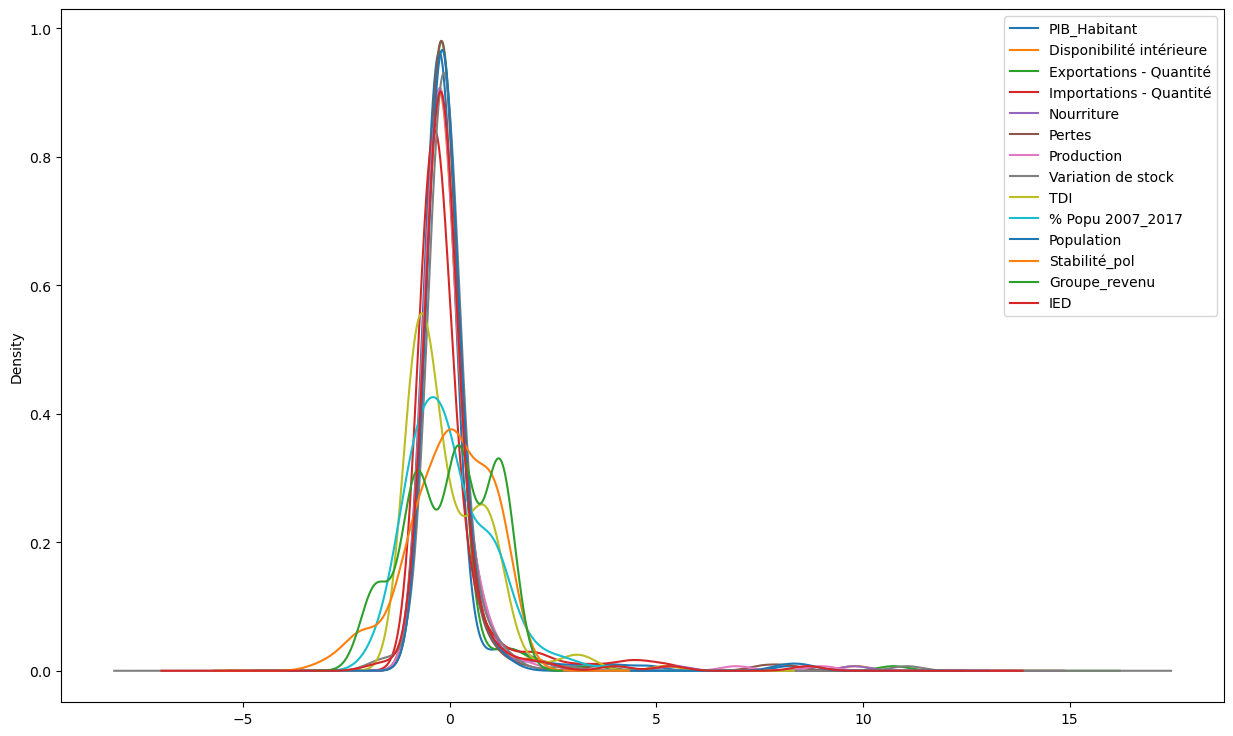

In [15]:
# Vérification des données après standardisation
X1 = pd.DataFrame(X_scaled,columns=X.columns).plot(kind='density',sharex=True,figsize=(15,9),layout=(10,1))
X1

Comme nous pouvons le voir, toutes les distributions sont maintenant centrées autour de la valeur 0 et ont une dispersion similaire. La variation dans les données est toujours préservée.

# 3. ACP

## 3.1. Application
#### [Retour](#Sommaire:)

In [16]:
# Select the number of principal components we will return
num_components = 14

# Create the PCA model
pca = PCA(n_components=num_components)

# Fit the model with the standardised data
pca.fit(X_scaled)

PCA(n_components=14)

### Taux de Variance Expliquée

Ceci est un tableau de la variance des données expliquée par chacune des 13 composantes principales, en commençant par CP1, la composante principale qui explique la plus grande partie de la variance.

In [17]:
pca.explained_variance_ratio_.round(2)

array([0.33, 0.17, 0.1 , 0.09, 0.08, 0.07, 0.05, 0.04, 0.03, 0.02, 0.01,
       0.  , 0.  , 0.  ])

si on somme les valeur du vecteur précédent on aura 1 qui veut dire 100% de l'information, on calcule la somme cumulative qui va aider dans le choix du nombre de composantes principales à choisir

In [18]:
pca.explained_variance_ratio_.cumsum().round(2)

array([0.33, 0.51, 0.61, 0.69, 0.78, 0.84, 0.89, 0.93, 0.96, 0.98, 1.  ,
       1.  , 1.  , 1.  ])

Selon le critère de Kaiser on garde les 6 premières composantes represente 84%

### Scree Plot

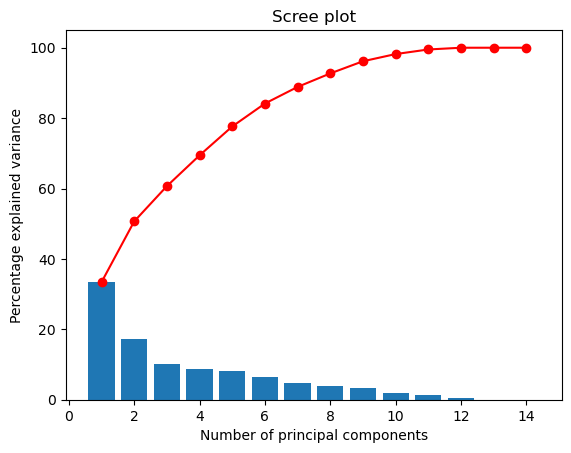

In [19]:
display_scree_plot(pca)

Les barres bleues montrent le pourcentage de variance expliquée par chaque composante principale. La ligne rouge montre la somme cumulative.

### Scores des composantes

À partir de l'objet pca généré, nous pouvons également obtenir les composantes, qui sont définies dans la documentation de Sklearn comme "Les axes principaux dans l'espace des caractéristiques, représentant les directions de la variance maximale dans les données".

In [20]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]
pc4 = pca.components_[3]
pc5 = pca.components_[4]
pc6 = pca.components_[5]

### 3.2. Cercles de corrélation
#### [Retour](#Sommaire:)

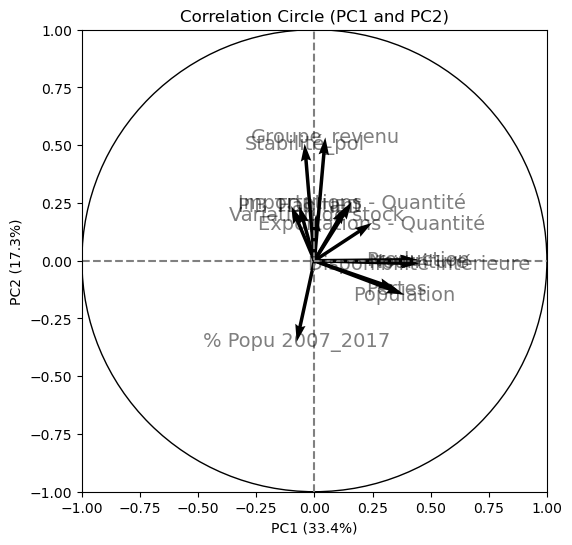

In [21]:
# Generate a correlation circle
pcs = pca.components_ 

display_circles(pcs, num_components, pca, [(0,1)], labels = np.array(X.columns),)

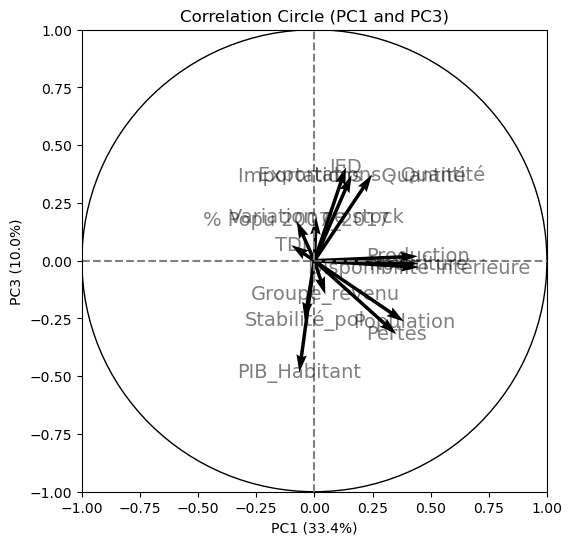

In [22]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(0,2)], labels = np.array(X.columns),)

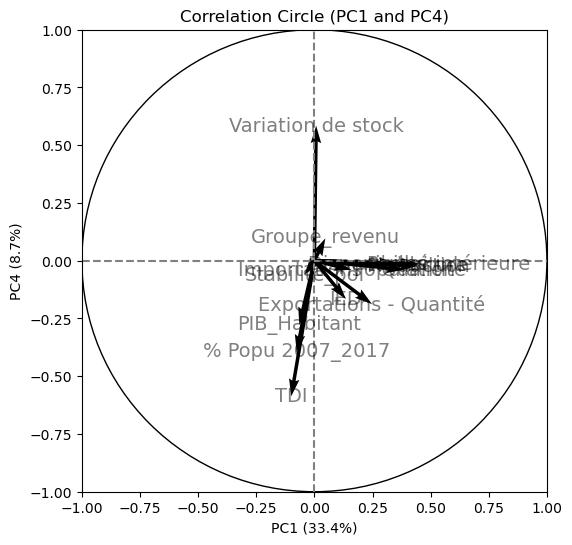

In [23]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(0,3)], labels = np.array(X.columns),)

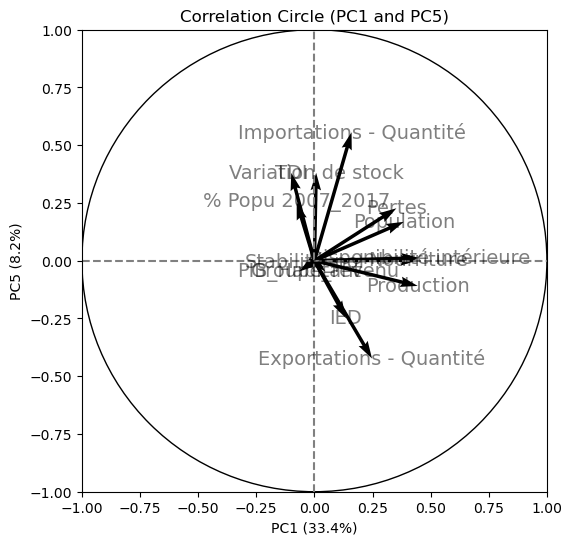

In [24]:
# Generate a correlation circle
pcs = pca.components_ 

display_circles(pcs, num_components, pca, [(0,4)], labels = np.array(X.columns),)

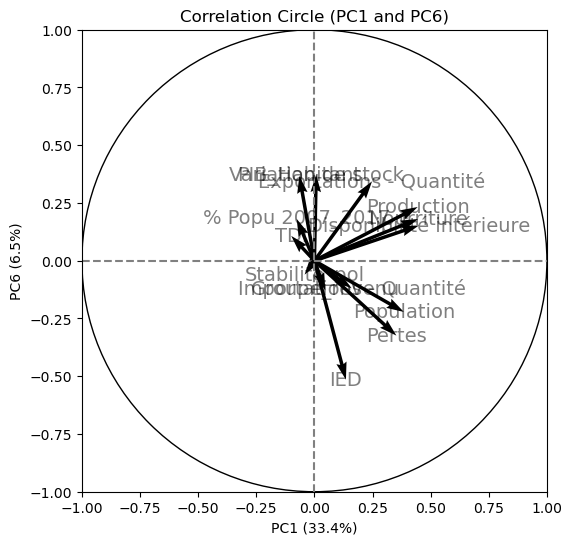

In [25]:
# Generate a correlation circle
pcs = pca.components_ 

display_circles(pcs, num_components, pca, [(0,5)], labels = np.array(X.columns),)

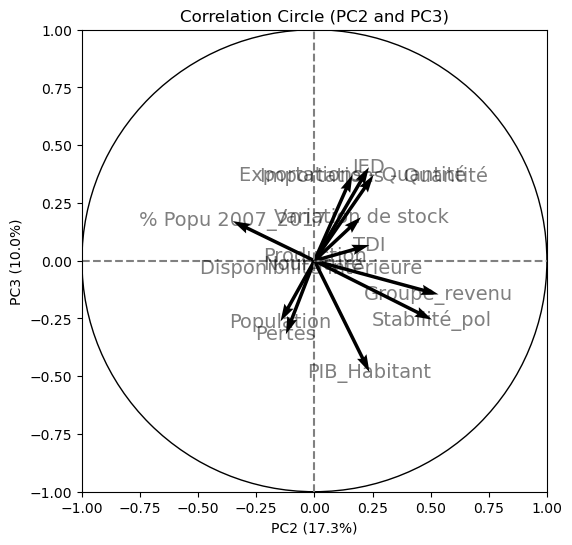

In [26]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(1,2)], labels = np.array(X.columns),)

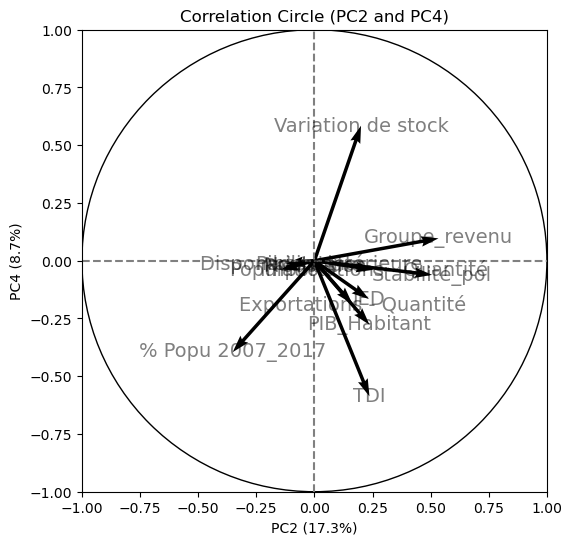

In [27]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(1,3)], labels = np.array(X.columns),)

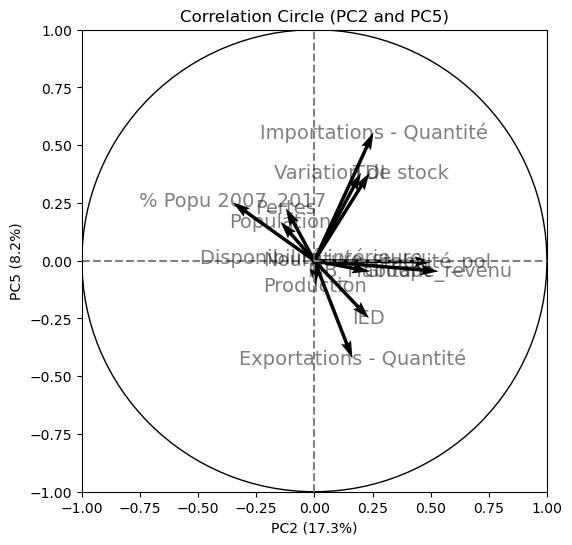

In [28]:
# Generate a correlation circle
pcs = pca.components_ 

display_circles(pcs, num_components, pca, [(1,4)], labels = np.array(X.columns),)

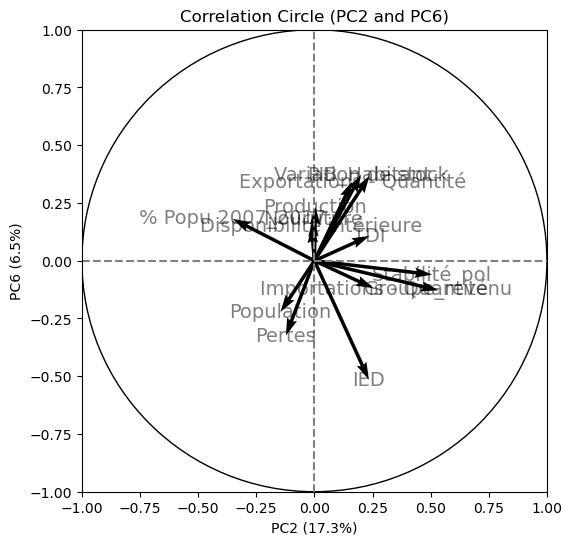

In [29]:
# Generate a correlation circle
pcs = pca.components_ 

display_circles(pcs, num_components, pca, [(1,5)], labels = np.array(X.columns))

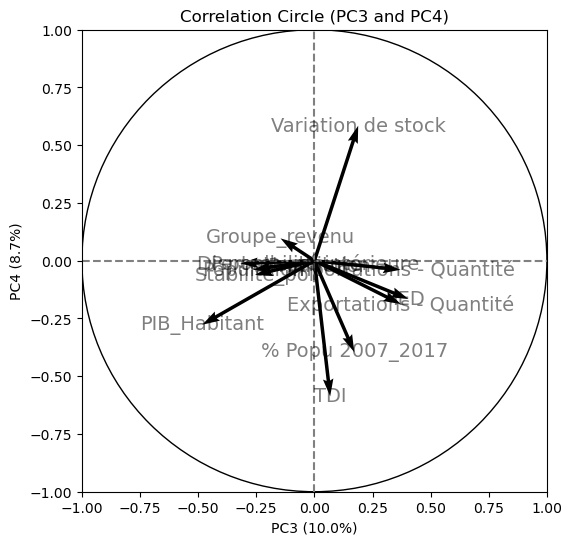

In [30]:
# Generate a correlation circle
pcs = pca.components_ 

display_circles(pcs, num_components, pca, [(2,3)], labels = np.array(X.columns))

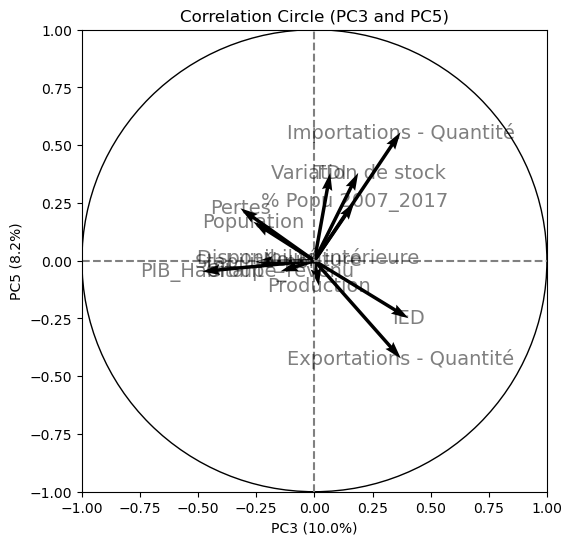

In [31]:
# Generate a correlation circle
pcs = pca.components_ 

display_circles(pcs, num_components, pca, [(2,4)], labels = np.array(X.columns))

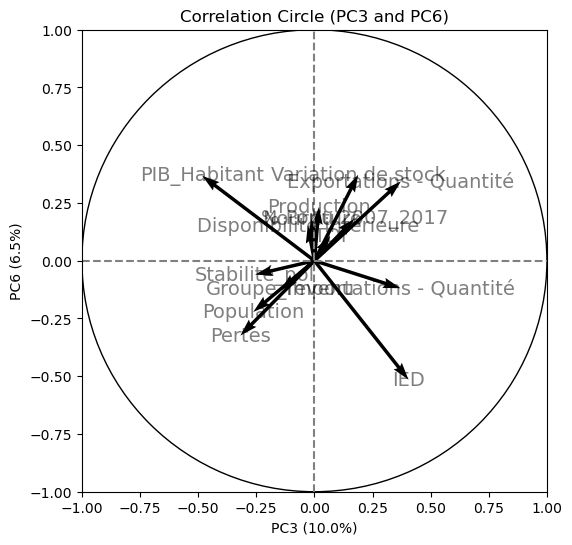

In [32]:
# Generate a correlation circle
pcs = pca.components_ 

display_circles(pcs, num_components, pca, [(2,5)], labels = np.array(X.columns))

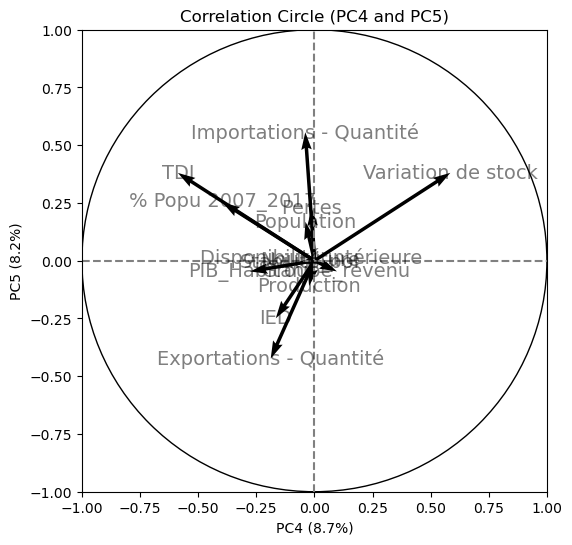

In [33]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(3,4)], labels = np.array(X.columns))

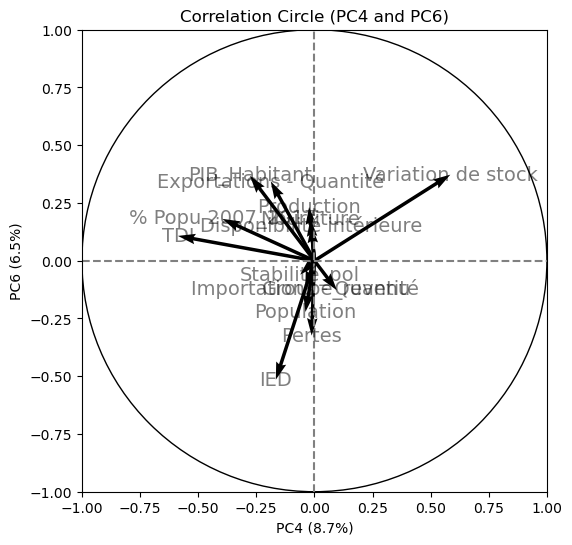

In [34]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(3,5)], labels = np.array(X.columns))

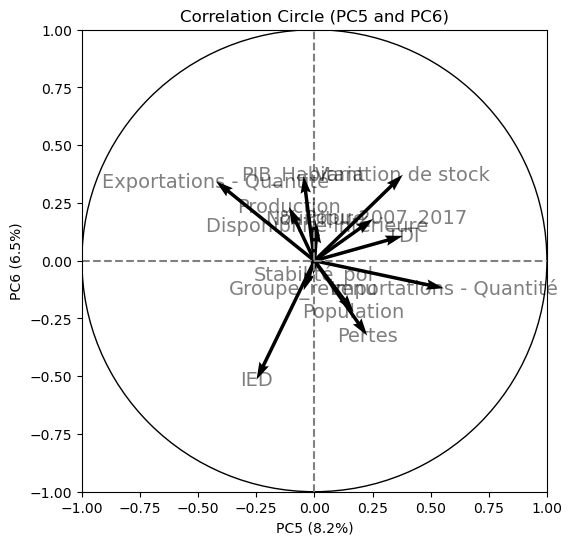

In [35]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, num_components, pca, [(4,5)], labels = np.array(X.columns))

In [36]:
# Définition de la fonction display_factorial_planes pour plotter les plans factoriels
def display_factorial_volume(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1, d2, d3 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(12, 15))
            ax = fig.add_subplot(111, projection='3d')  # Create a 3D axes

            # affichage des points
            if illustrative_var is None:
                ax.scatter(X_projected[:, d1], X_projected[:, d2], X_projected[:, d3], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    ax.scatter(X_projected[selected, d1], X_projected[selected, d2], X_projected[selected, d3], alpha=alpha, label=value)
                ax.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y, z) in enumerate(X_projected[:, [d1, d2, d3]]):
                    ax.text(x, y, z, labels[i], fontsize='10', ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2, d3]])) * 1.1
            ax.set_xlim([-20, 20])
            ax.set_ylim([-20, 20])
            ax.set_zlim([-20, 20])

            # affichage des lignes horizontales et verticales
            ax.plot([-20, 20], [0, 0], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-20, 20], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [0, 0], [-20, 20], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            ax.set_ylabel('F{} ({}%)'.format(d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)))
            ax.set_zlabel('F{} ({}%)'.format(d3 + 1, round(100 * pca.explained_variance_ratio_[d3], 1)))

            plt.title("Projection des individus (sur F{} et F{} et F{})".format(d1 + 1, d2 + 1, d3 + 1), fontsize=16, fontweight='bold')
            plt.show(block=False)

Representation des individus sur l'espace 3D **CP1**X**CP2**X**CP3**

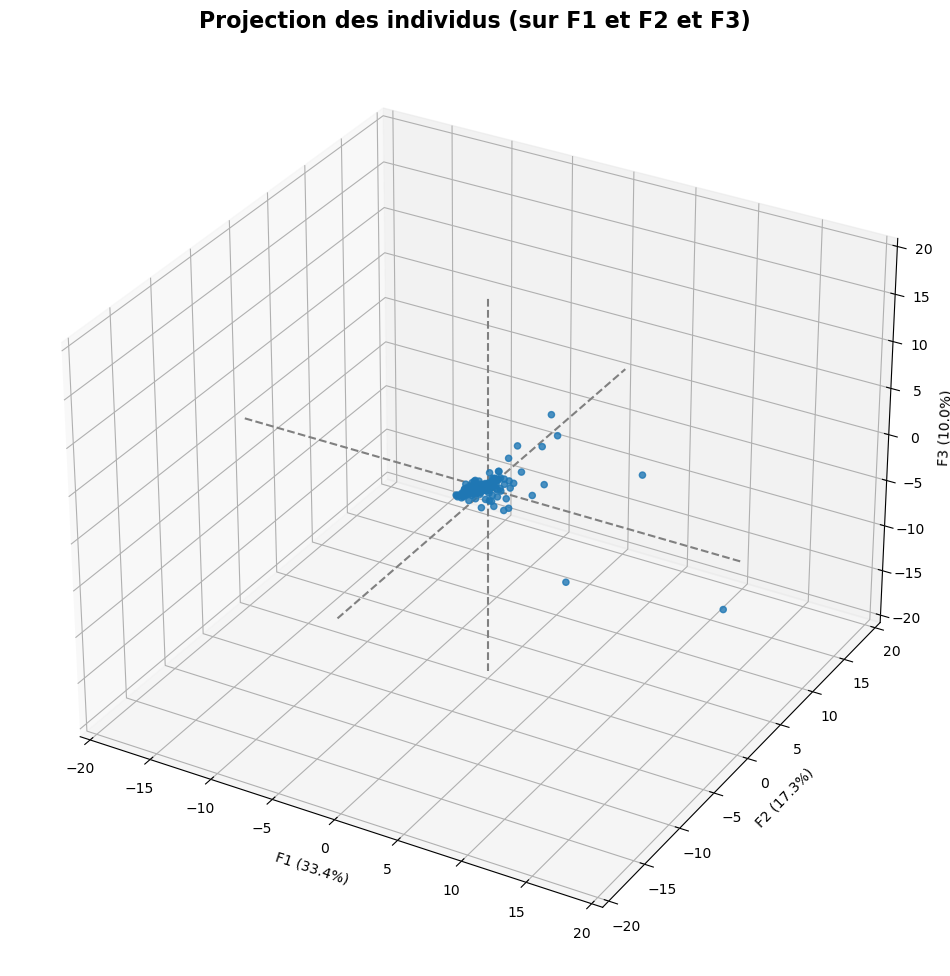

In [37]:
# Transform the original scaled data to the new vector space
X_projected = pca.transform(X_scaled) 
# Example usage:
display_factorial_volume(X_projected, 6, pca, [(0, 1, 2)], alpha=0.8)

### 3.3. Plans factoriels
#### [Retour](#Sommaire:)

In [38]:
# Définition de la fonction display_factorial_planes pour plotter les plans factoriels
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure       
            fig = plt.figure(figsize=(6, 6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:,[d1, d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='10', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1), fontsize=16, fontweight='bold')
            plt.show(block=False)

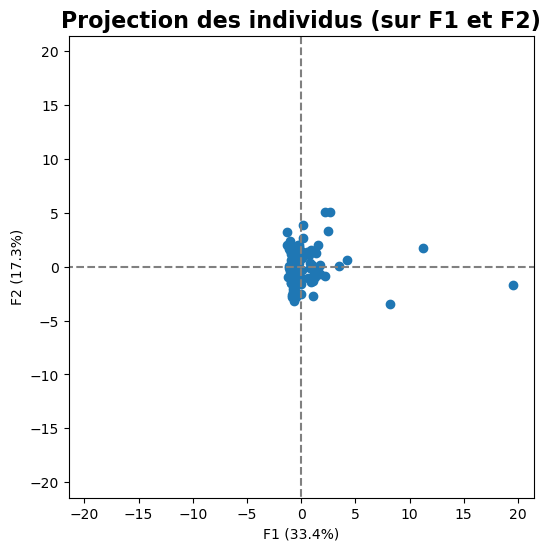

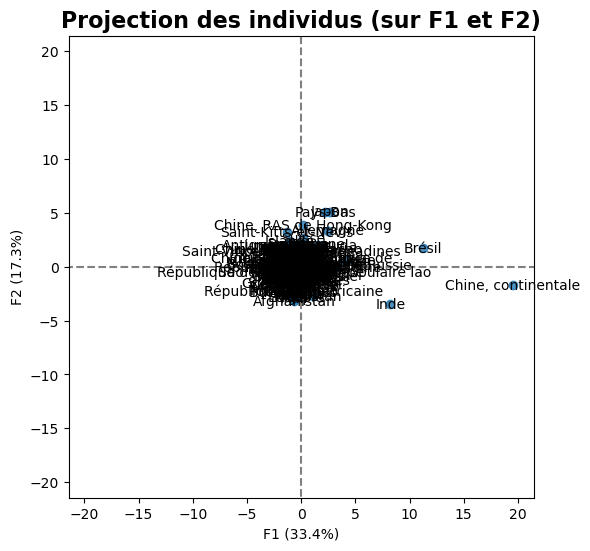

In [39]:
# Transform the original scaled data to the new vector space
X_projected = pca.transform(X_scaled) 

# Display a scatter plot of the data points in this new vector space
display_factorial_planes(X_projected, num_components, pca, [(0,1)])
display_factorial_planes(X_projected, 8, pca, [(0, 1)], labels=data.reset_index()['Pays'], alpha=0.8)

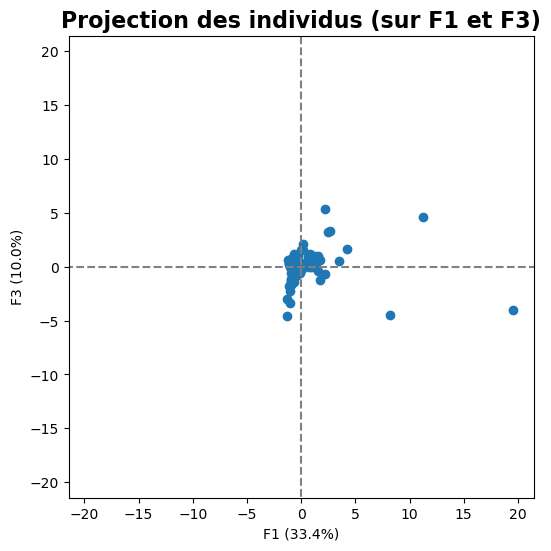

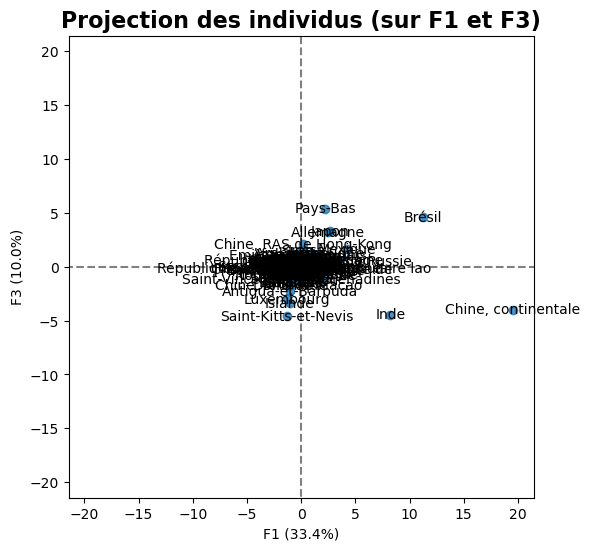

In [40]:
# Display a scatter plot of the data points in this new vector space
display_factorial_planes(X_projected, num_components, pca, [(0,2)])
# Ajout des noms des pays
display_factorial_planes(X_projected, num_components, pca, [(0,2)], labels=data.reset_index()['Pays'], alpha=0.8)

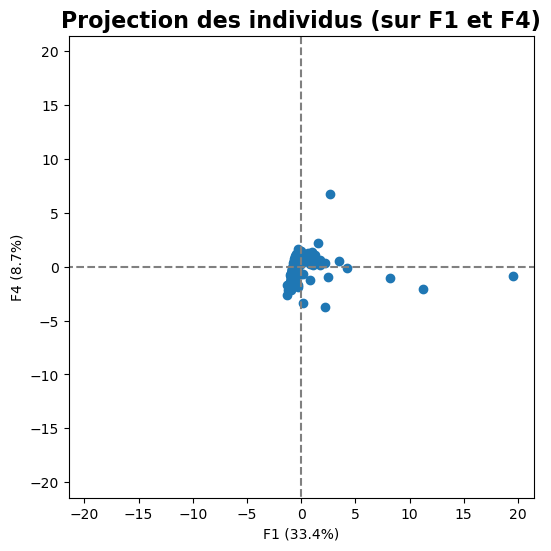

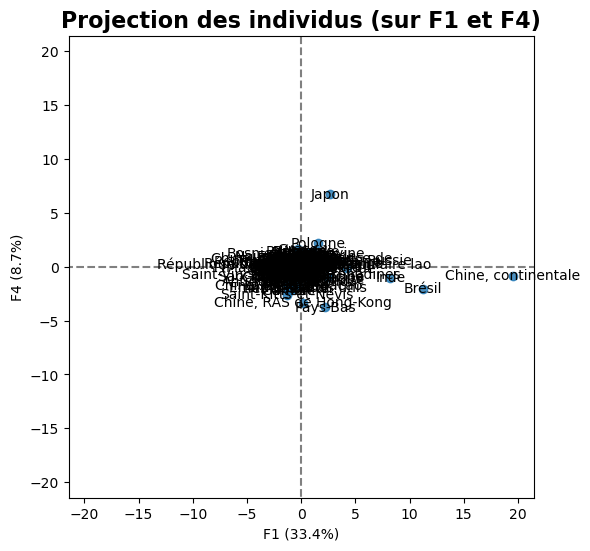

In [41]:
# Display a scatter plot of the data points in this new vector space
display_factorial_planes(X_projected, num_components, pca, [(0,3)])
display_factorial_planes(X_projected, 4, pca, [(0, 3)], labels=data.reset_index()['Pays'], alpha=0.8)

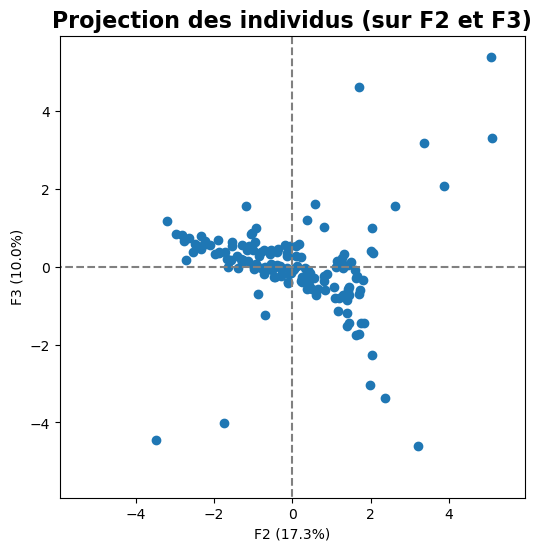

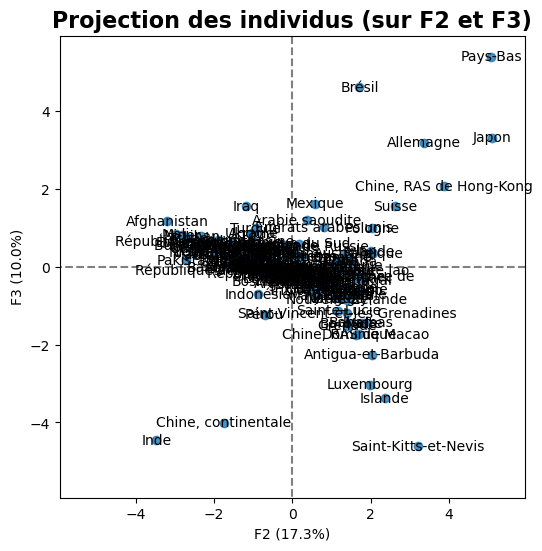

In [42]:
# Display a scatter plot of the data points in this new vector space
display_factorial_planes(X_projected, num_components, pca, [(1,2)])
display_factorial_planes(X_projected, 4, pca, [(1, 2)], labels=data.reset_index()['Pays'], alpha=0.8)

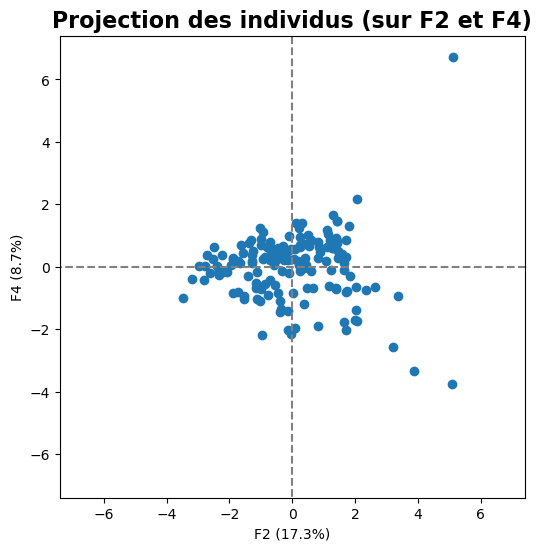

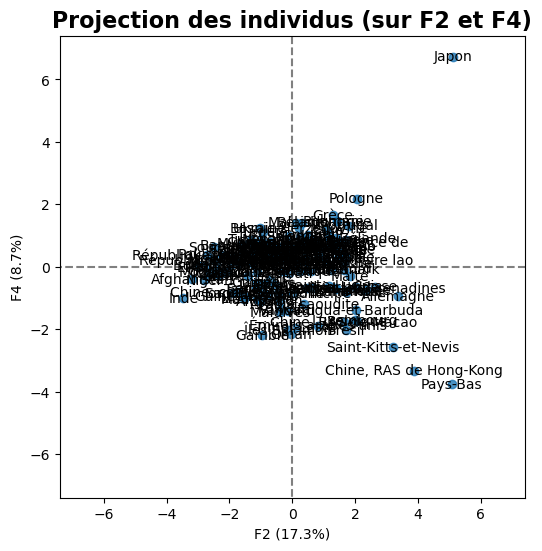

In [43]:
# Display a scatter plot of the data points in this new vector space
display_factorial_planes(X_projected, num_components, pca, [(1,3)])
display_factorial_planes(X_projected, 4, pca, [(1, 3)], labels=data.reset_index()['Pays'], alpha=0.8)

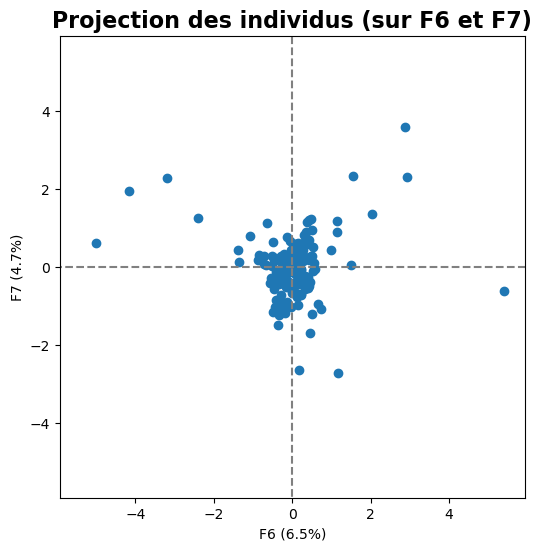

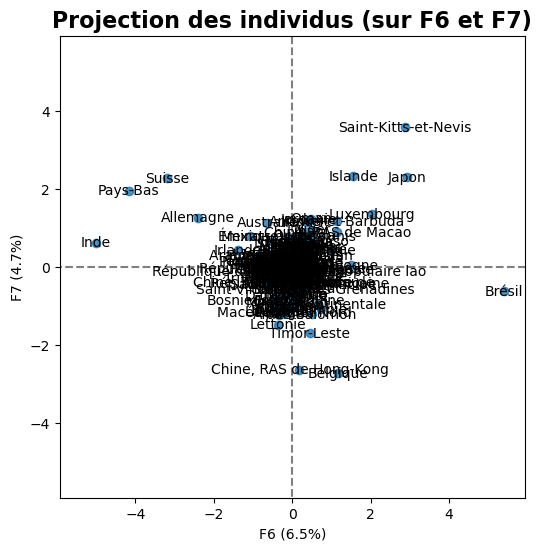

In [44]:
# Display a scatter plot of the data points in this new vector space
display_factorial_planes(X_projected, num_components, pca, [(5,6)])
display_factorial_planes(X_projected, 8, pca, [(5, 6)], labels=data.reset_index()['Pays'], alpha=0.8)

# 4. K-Means

## 4.1. Application K-Means
#### [Retour](#Sommaire:)

In [45]:
# Creation d-un modèle de clustering k-means
kmeans = KMeans(init='random', n_clusters=10, n_init=10)

# Fit the data to the model
kmeans.fit(X_scaled)

# Determinion des individus de chaques cluster
clustersKmeans =  kmeans.predict(X_scaled)

## 4.2. Séléction du nombre des clusters
#### [Retour](#Sommaire:)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


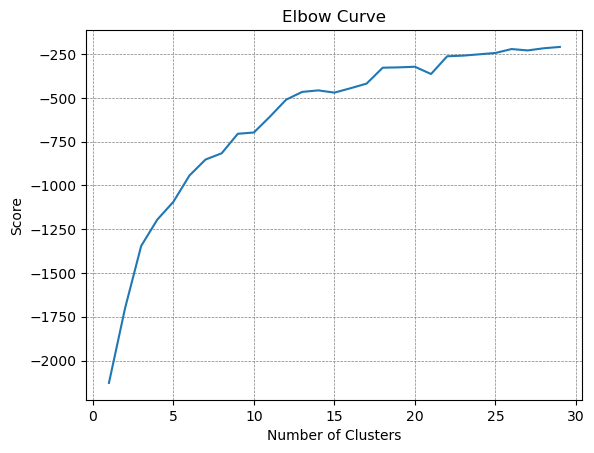

In [46]:
# Run a number of tests, for 1, 2, ... num_clusters
num_clusters = 30
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=13) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [47]:
# Create a k-means clustering model
kmeans = KMeans(init='random', n_clusters=6, n_init=10)

# Fit the data to the model
kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to:
clustersKmeans =  kmeans.predict(X_scaled)

In [48]:
# Add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clustersKmeans

X_scaled_clustered.head()

PIB_Habitant  Disponibilité intérieure  Exportations - Quantité  \
0     -0.304916                 -0.293386                -0.219010   
1     -0.302760                  0.856677                -0.063257   
2     -0.268973                 -0.298966                -0.226798   
3     -0.302947                 -0.170623                -0.226798   
4     -0.292728                  0.645191                 1.450138   

   Importations - Quantité  Nourriture    Pertes  Production  \
0                -0.310850   -0.286595 -0.225610   -0.289640   
1                 2.318021    0.856096  0.760443    0.545603   
2                -0.262067   -0.291212 -0.213436   -0.297284   
3                -0.457200   -0.165978 -0.091702   -0.163768   
4                 4.095897    0.610244 -0.213436    0.467634   

   Variation de stock       TDI  % Popu 2007_2017  Population  Stabilité_pol  \
0           -0.163652  0.082077          1.211909   -0.039447      -3.136157   
1           -0.163652 -0.422239          0.024239    0.089753      -0.282437   
2           -0.111366  0.650165         -1.371641   -0.247852       0.464966   
3           -0.163652 -0.868504          0.361575   -0.007679      -1.007191   
4           -0.542727  0.035480         -0.930504    0.249736       0.702776   

   Groupe_revenu       IED  cluster  
0      -1.783860 -0.288339        4  
1       0.217223 -0.209235        3  
2       0.217223 -0.250060        3  
3      -0.783319 -0.241883        4  
4       1.217764  4.005662        0

## 4.3. Analyse des résultats
#### [Retour](#Sommaire:)

In [49]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=6)
pca.fit(X_scaled)

# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(X_scaled)

In [50]:
# Conversion du dataframe
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2','PC3','PC4','PC5','PC6'])
X_reduceddf['cluster'] = clustersKmeans
X_reduceddf.head()

PC1       PC2       PC3       PC4       PC5       PC6  cluster
0 -0.660028 -3.196060  1.165503 -0.398891  0.347612  0.500963        4
1  1.719020  0.169116  0.591593  0.169395  1.297575 -0.268052        3
2 -0.651880  0.805632 -0.376118  0.285414 -0.191239 -0.335929        3
3 -0.337856 -1.560394  0.172950  0.451847 -0.350825 -0.000689        4
4  2.457664  3.359701  3.188621 -0.948668  0.144759 -2.394166        0

In [51]:
centres_reduced = pca.transform(kmeans.cluster_centers_)

In [52]:
# Nombre d'individus dans chaqu'un des 6 clusters:
liste1 = X_reduceddf['cluster'].unique()
for i in liste1:
    print('cluster ',i,':',np.bincount(clustersKmeans)[i])

cluster  4 : 47
cluster  3 : 69
cluster  0 : 5
cluster  5 : 20
cluster  1 : 8
cluster  2 : 3


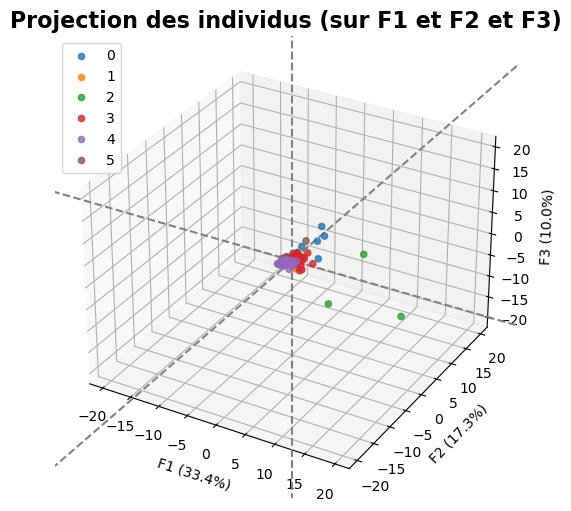

In [53]:
# Définition de la fonction display_factorial_planes pour plotter les plans factoriels
def display_factorial_volume(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1, d2, d3 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(6, 6))
            ax = fig.add_subplot(111, projection='3d')  # Create a 3D axes

            # affichage des points
            if illustrative_var is None:
                ax.scatter(X_projected[:, d1], X_projected[:, d2], X_projected[:, d3], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    ax.scatter(X_projected[selected, d1], X_projected[selected, d2], X_projected[selected, d3], alpha=alpha, label=value)
                ax.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y, z) in enumerate(X_projected[:, [d1, d2, d3]]):
                    ax.text(x, y, z, labels[i], fontsize='10', ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2, d3]])) * 1.1
            ax.set_xlim([-boundary, boundary])
            ax.set_ylim([-boundary, boundary])
            ax.set_zlim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            ax.plot([-100, 100], [0, 0], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-100, 100], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            ax.set_ylabel('F{} ({}%)'.format(d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)))
            ax.set_zlabel('F{} ({}%)'.format(d3 + 1, round(100 * pca.explained_variance_ratio_[d3], 1)))

            plt.title("Projection des individus (sur F{} et F{} et F{})".format(d1 + 1, d2 + 1, d3 + 1), fontsize=16, fontweight='bold')
            plt.show(block=False)

# Example usage:
display_factorial_volume(X_reduced, 6, pca, [(0,1,2)], illustrative_var=clustersKmeans, alpha=0.8)


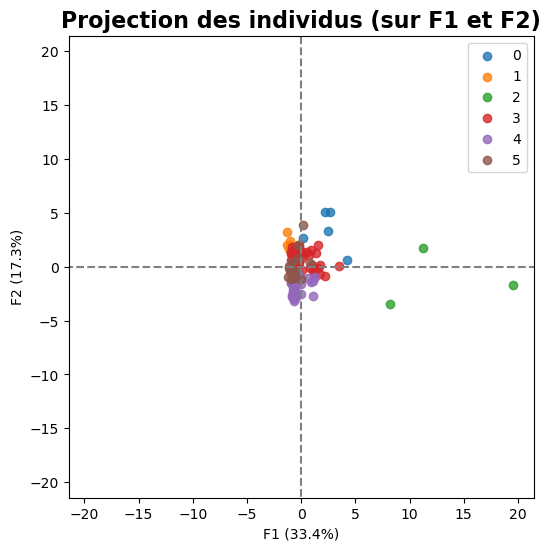

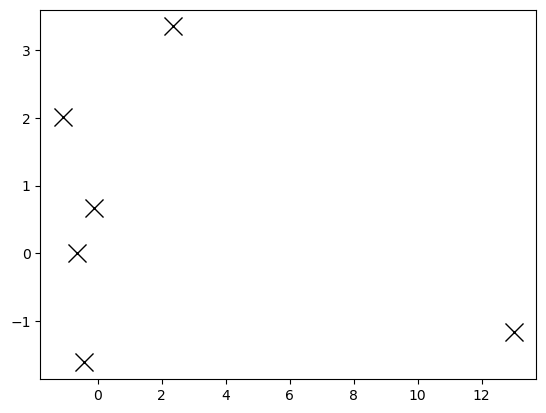

In [54]:
display_factorial_planes(X_reduced, 6, pca, [(0,1)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

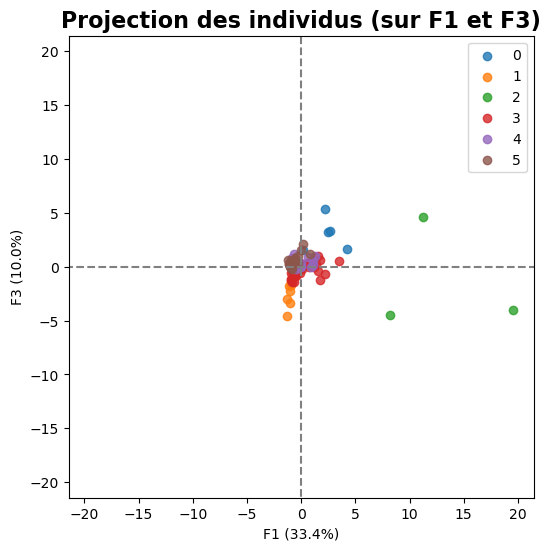

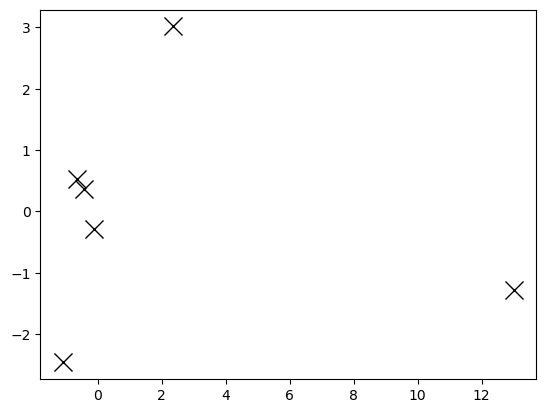

In [55]:
display_factorial_planes(X_reduced, 6, pca, [(0,2)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 2],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

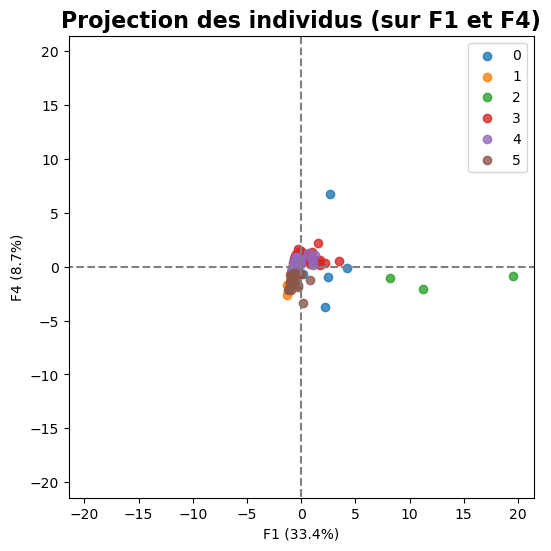

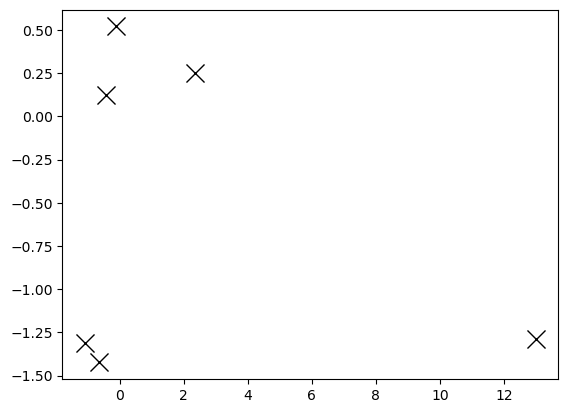

In [56]:
display_factorial_planes(X_reduced, 6, pca, [(0,3)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 3],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

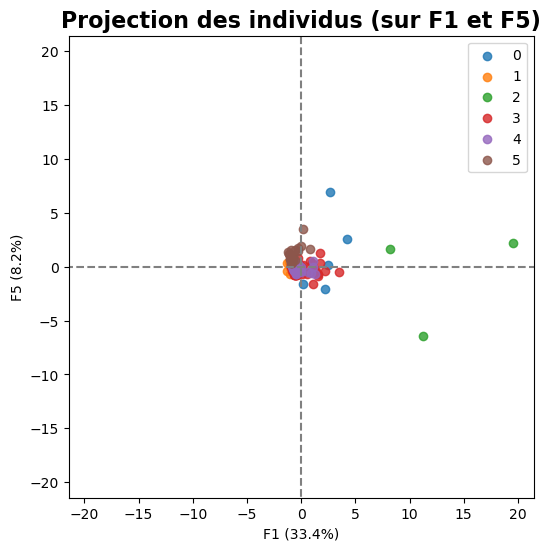

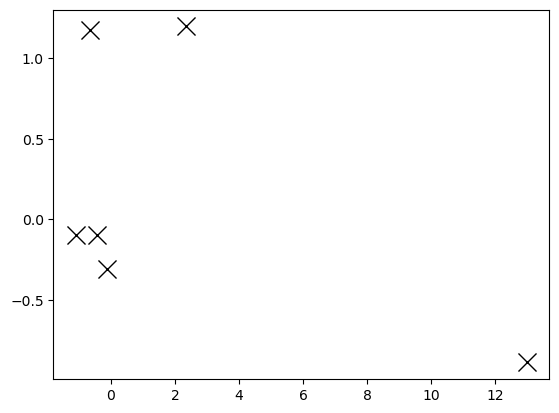

In [57]:
display_factorial_planes(X_reduced, 6, pca, [(0,4)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 4],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

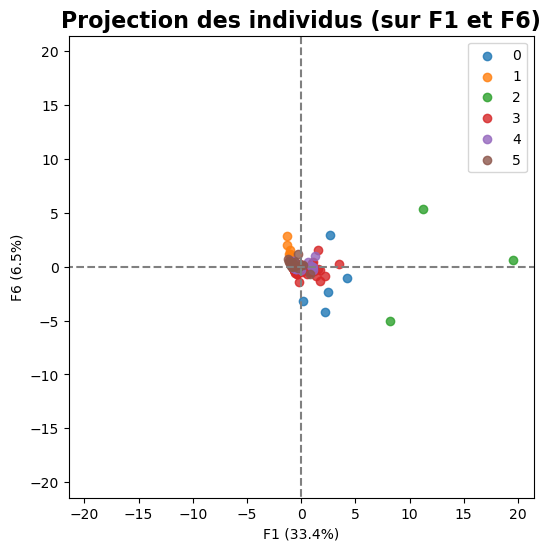

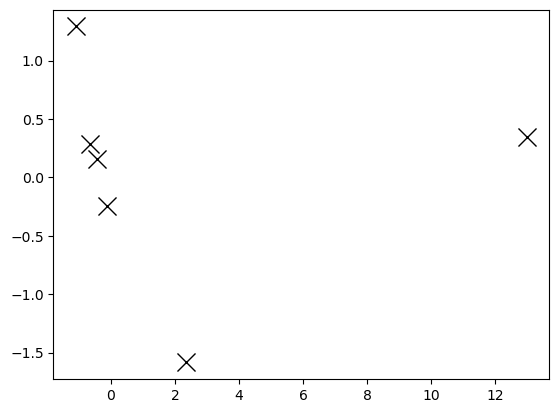

In [58]:
display_factorial_planes(X_reduced, 6, pca, [(0,5)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 5],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

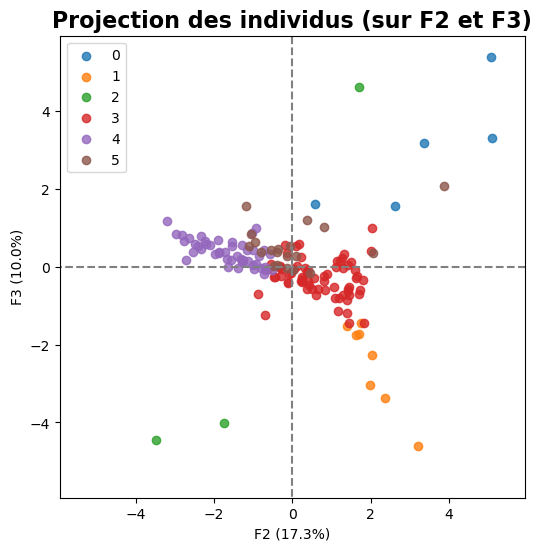

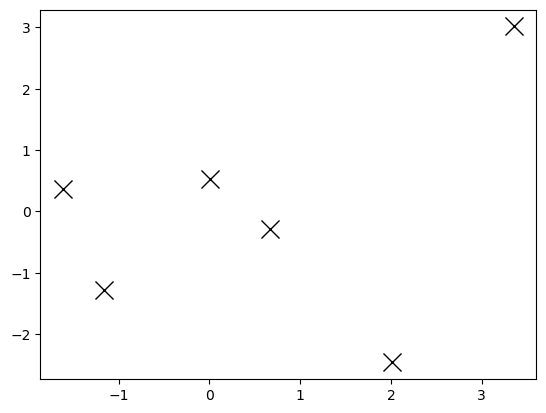

In [59]:
display_factorial_planes(X_reduced, 6, pca, [(1,2)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 1], centres_reduced[:, 2],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

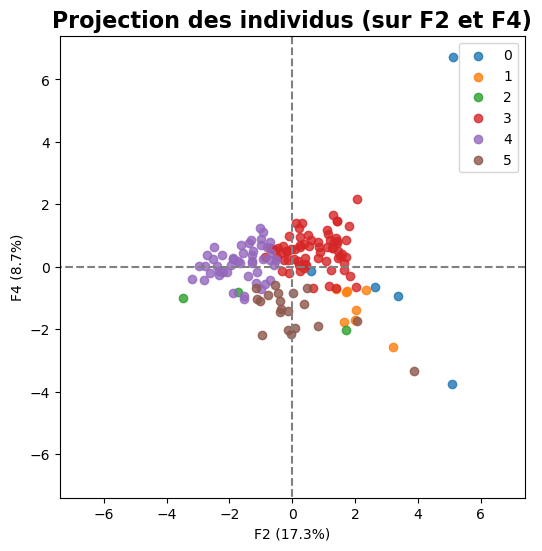

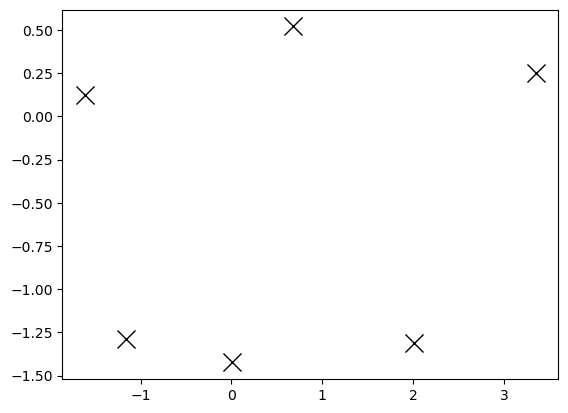

In [60]:
display_factorial_planes(X_reduced, 6, pca, [(1,3)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 1], centres_reduced[:, 3],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

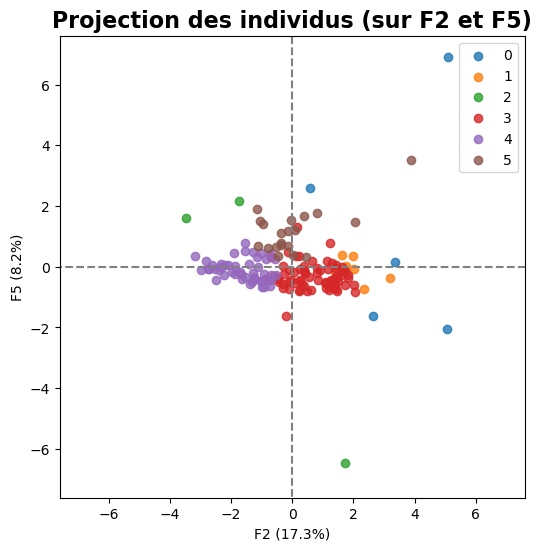

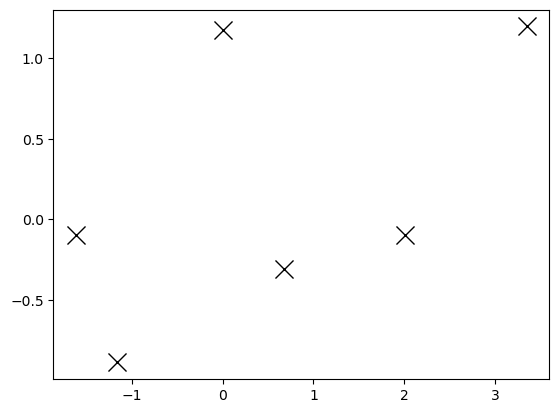

In [61]:
display_factorial_planes(X_reduced, 6, pca, [(1,4)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 1], centres_reduced[:, 4],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

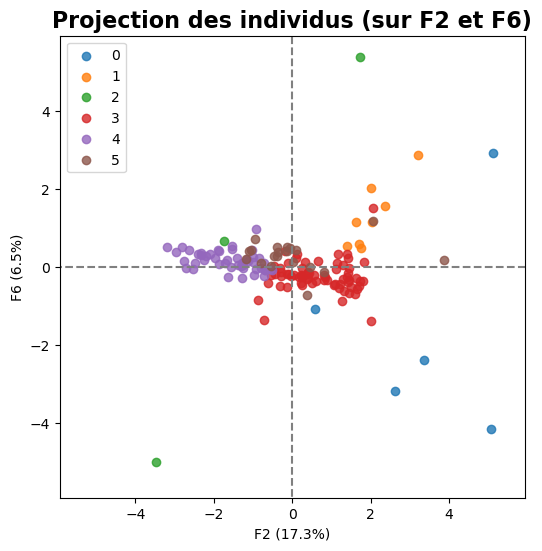

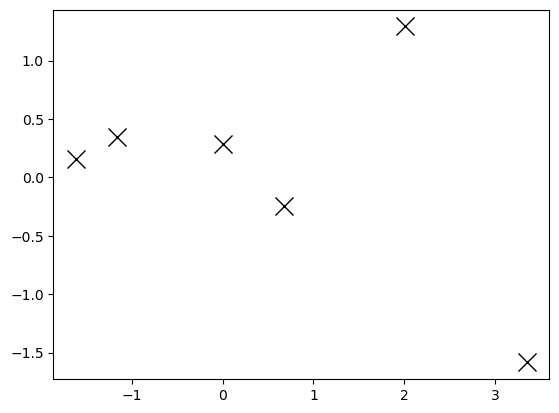

In [62]:
display_factorial_planes(X_reduced, 6, pca, [(1,5)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 1], centres_reduced[:, 5],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

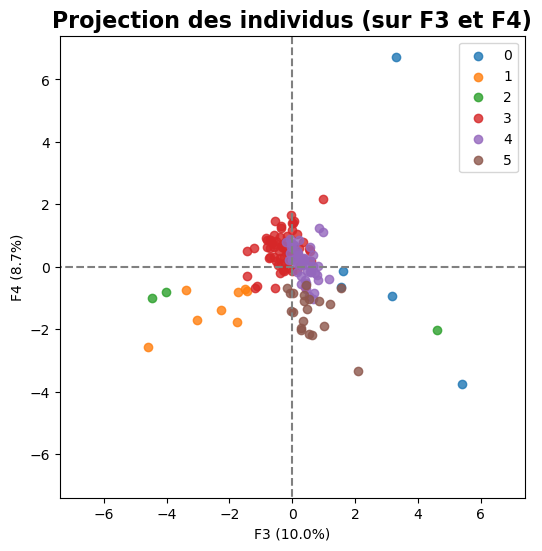

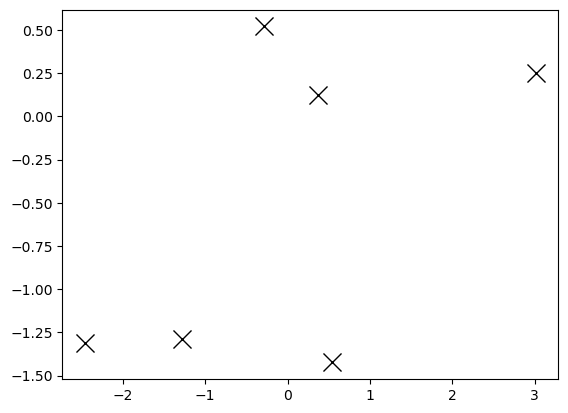

In [63]:
display_factorial_planes(X_reduced, 6, pca, [(2,3)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 2], centres_reduced[:, 3],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

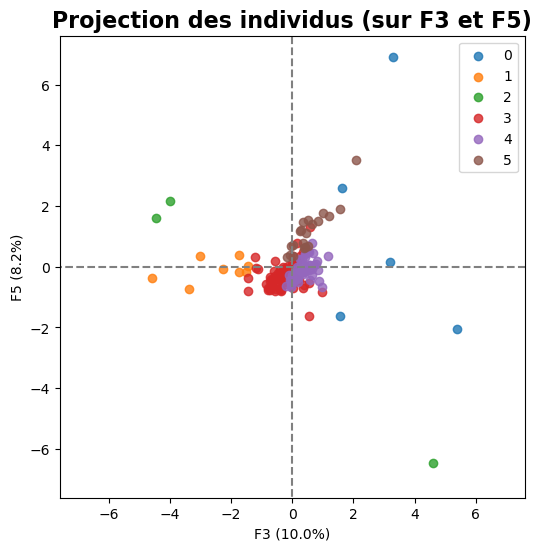

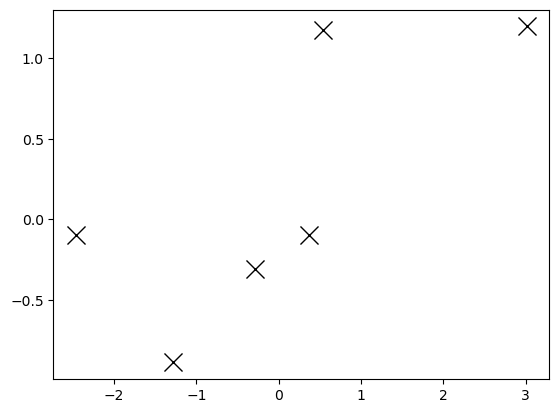

In [64]:
display_factorial_planes(X_reduced, 6, pca, [(2,4)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 2], centres_reduced[:, 4],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

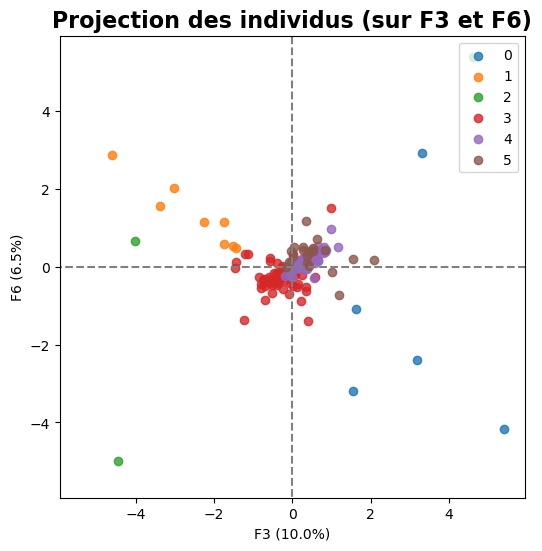

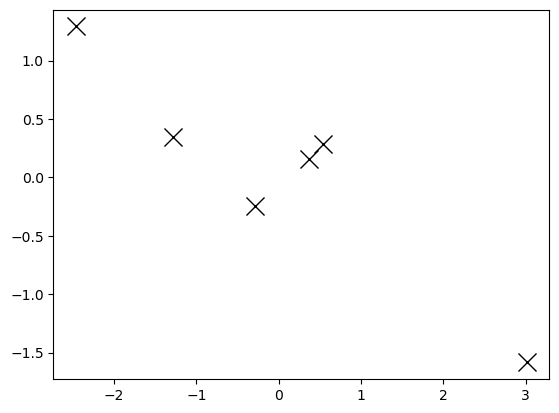

In [65]:
display_factorial_planes(X_reduced, 6, pca, [(2,5)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 2], centres_reduced[:, 5],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

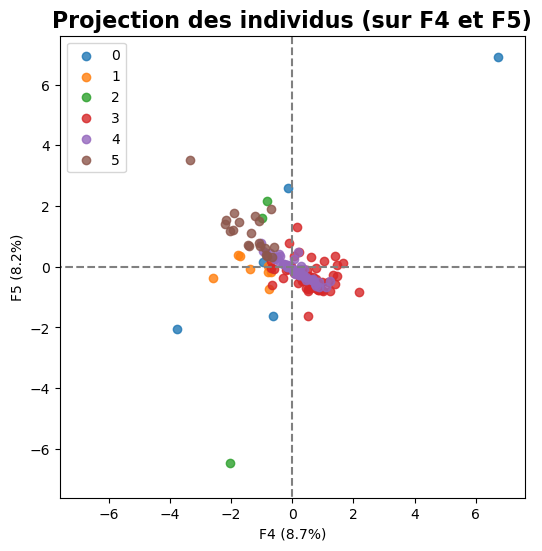

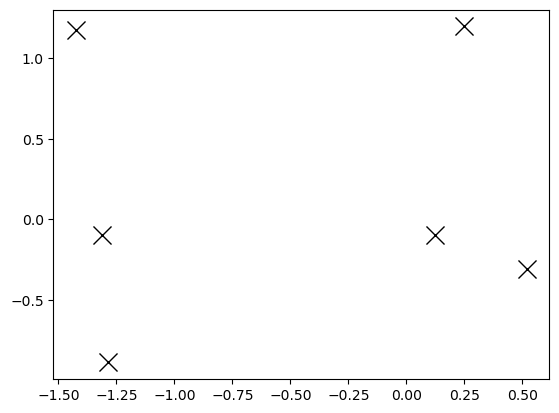

In [66]:
display_factorial_planes(X_reduced, 6, pca, [(3,4)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 3], centres_reduced[:, 4],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

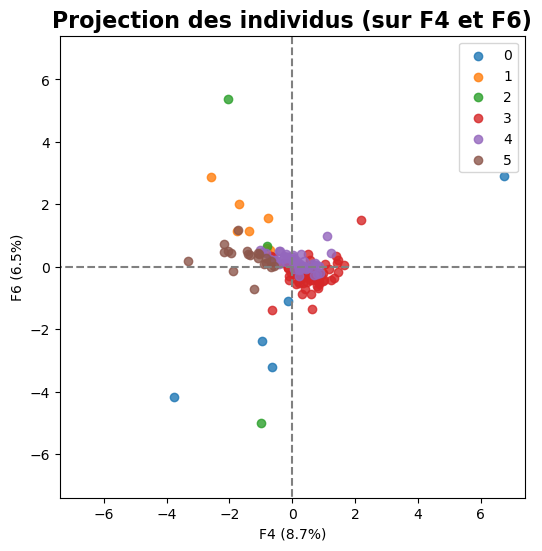

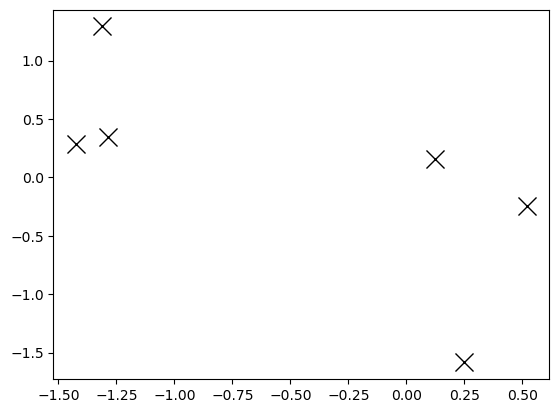

In [67]:
display_factorial_planes(X_reduced, 6, pca, [(3,5)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 3], centres_reduced[:, 5],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

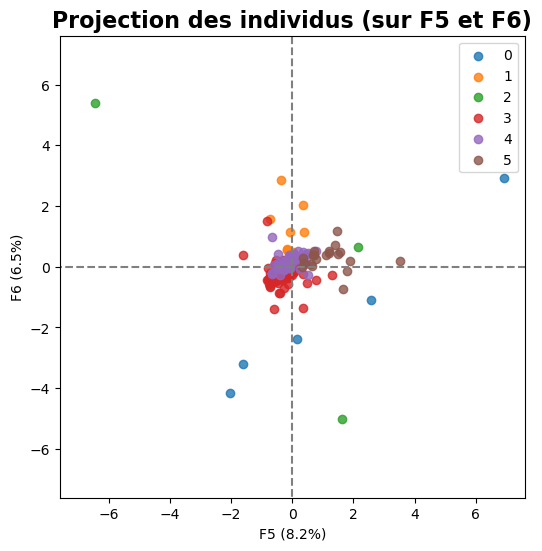

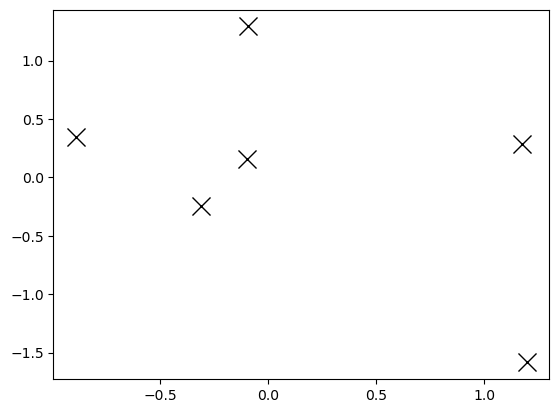

In [68]:
display_factorial_planes(X_reduced, 6, pca, [(4,5)], illustrative_var = clustersKmeans, alpha = 0.8)
plt.scatter(centres_reduced[:, 4], centres_reduced[:, 5],
            marker='x', s=169, linewidths=1,
            color='k', zorder=10)
plt.show()

## 4.4. Interpretation des Clusters
#### [Retour](#Sommaire:)

#### Parallel Coordinates Plot
Le "graphe des coordonnées parallèles" (en anglais, "parallel coordinates plot" ou "parallel coordinates chart") est un type de visualisation couramment utilisé pour afficher des données multivariées, en particulier lorsqu'on travaille avec de nombreuses variables continues.

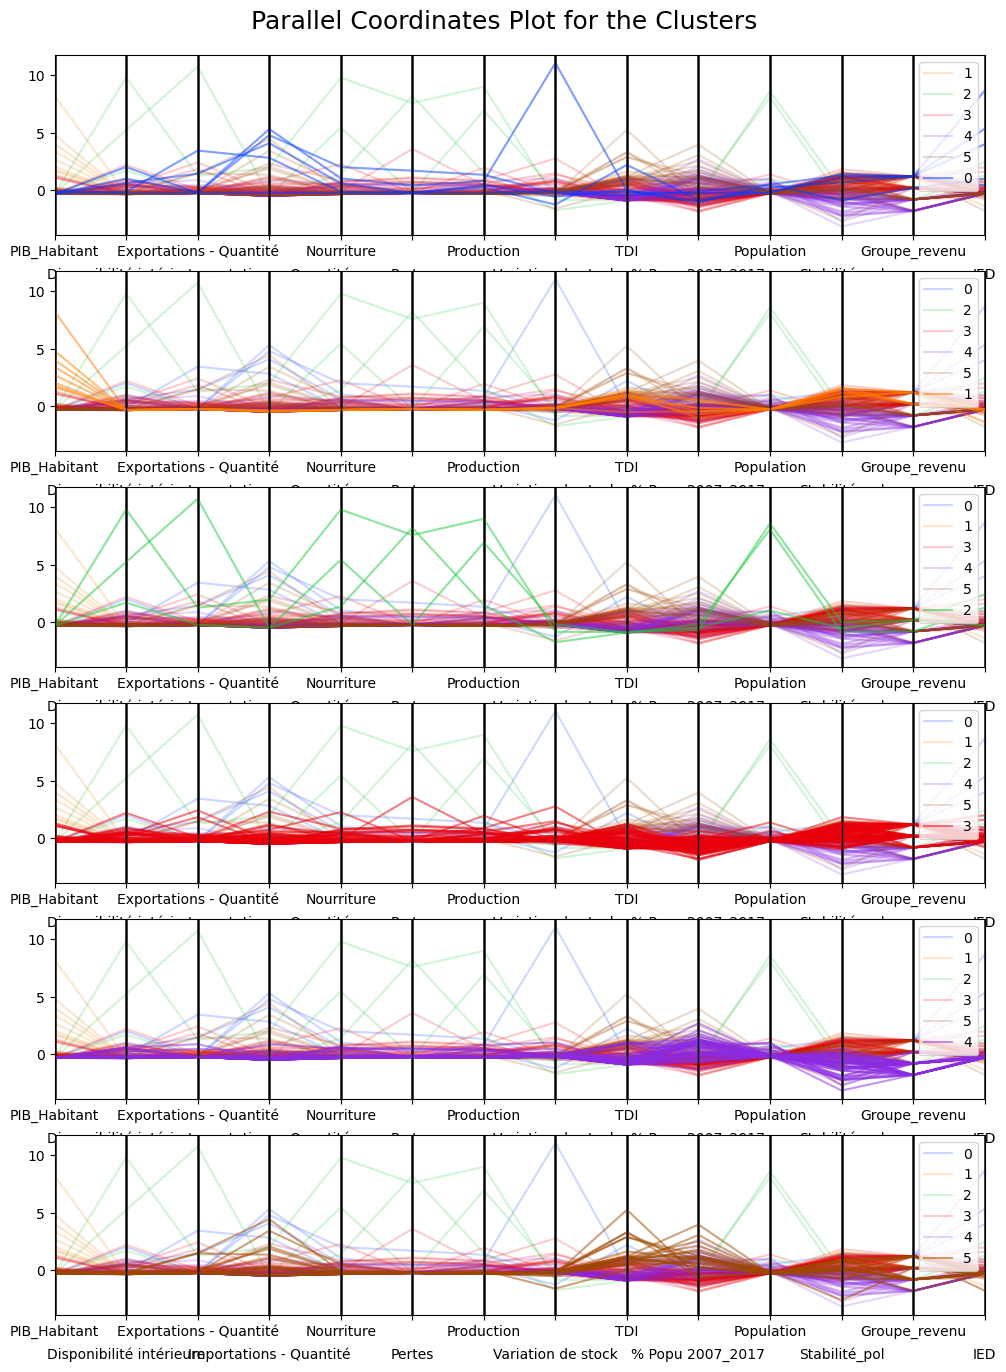

In [69]:
# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered["cluster"] = clustersKmeans

# Display parallel coordinates plots, one for each cluster
display_parallel_coordinates(X_clustered, 6)

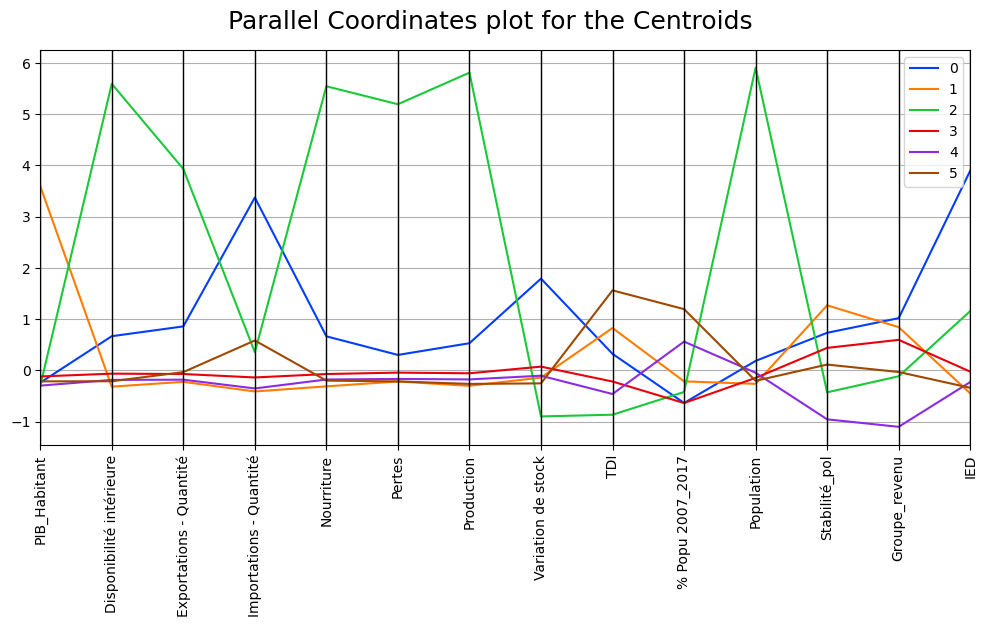

In [70]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 6)

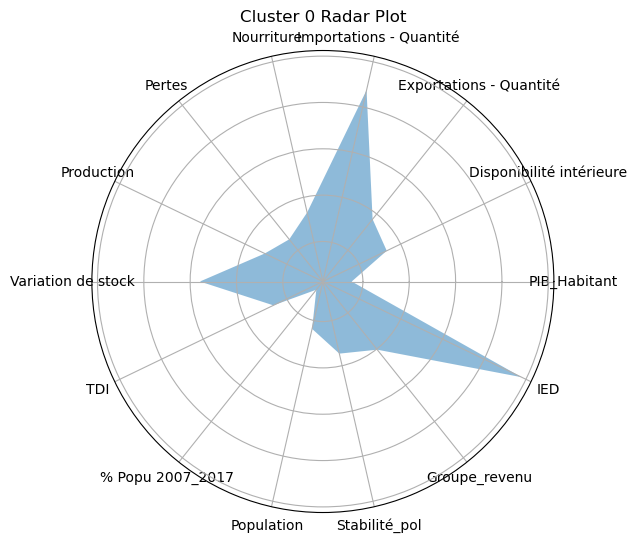

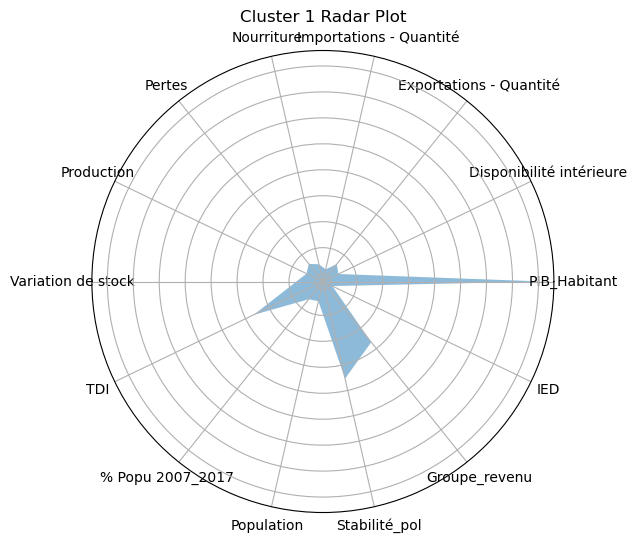

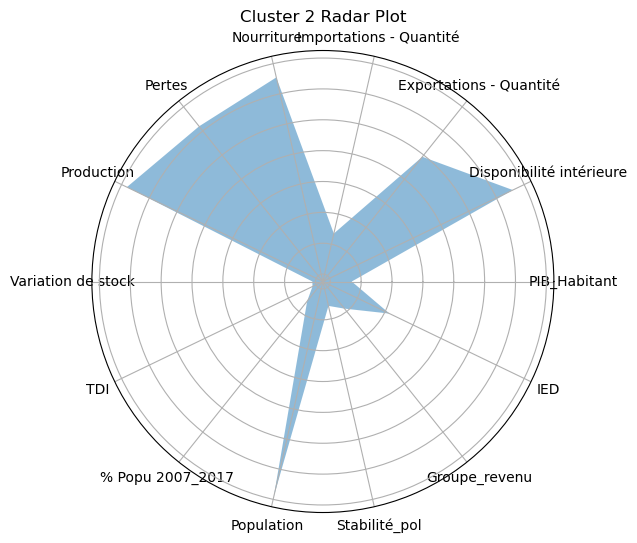

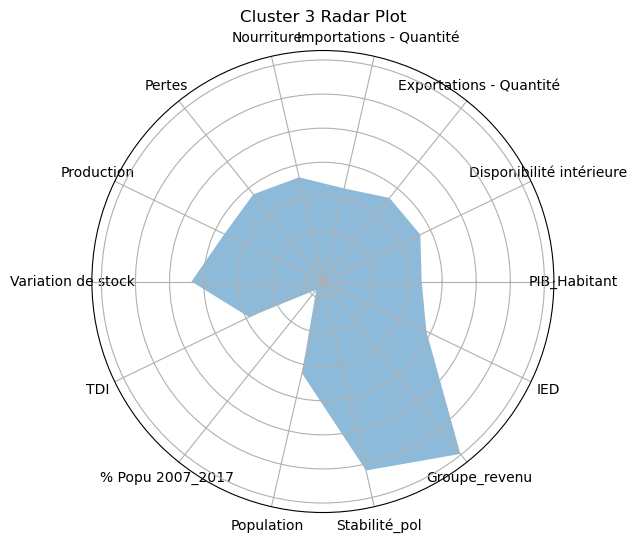

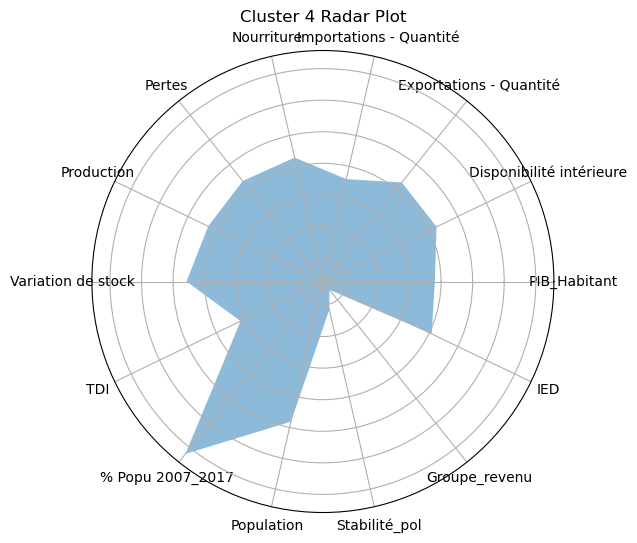

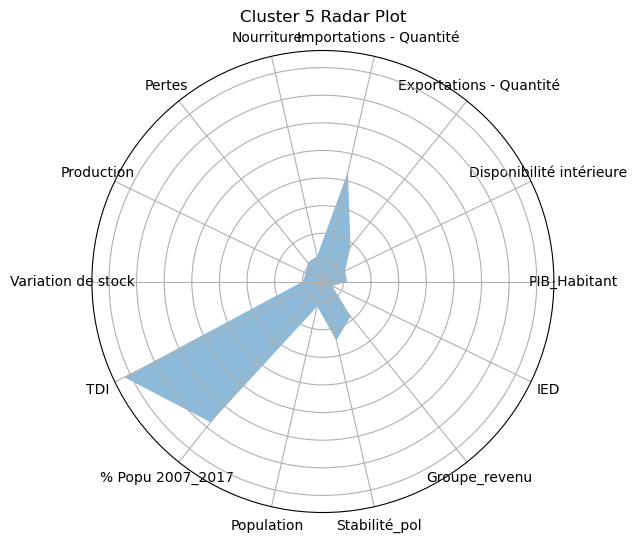

In [71]:

# Fonction pour afficher un graphique en forme de radar pour un cluster donné
def radar_plot_for_cluster(data, cluster_num):
    categories = list(data.columns[:-1])  # Excluez la colonne 'cluster'
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

    values = data.loc[cluster_num].drop('cluster').values.flatten().tolist()
    values += values[:1]

    ax.fill(angles, values, alpha=0.5)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels([])  # Vous pouvez supprimer les étiquettes de l'axe radial si vous le souhaitez
    ax.set_title(f'Cluster {cluster_num} Radar Plot')

    plt.show()

# Utilisez la fonction radar_plot_for_cluster pour afficher les graphiques en forme de radar pour chaque cluster
cluster_count = len(centroids)
for cluster_num in range(cluster_count):
    radar_plot_for_cluster(centroids, cluster_num)

In [72]:
# Récupération des noms de clusters par pays
clusters_name1 = X_reduceddf.iloc[:,-2:]
# Ajout des clusters dans df
data1 = data.merge(clusters_name1, on = data.index)
data1.rename(columns={"key_0":"Pays"}, inplace= True)
data
# affichage des différents clusters
liste = data1['cluster'].unique()
for i in liste:
    display(data1.loc[data1['cluster']==i, ['Pays','cluster']])

Pays                                   Pays  cluster
0      0                            Afghanistan        4
3      3                                Algérie        4
14    14                             Bangladesh        4
24    24                           Burkina Faso        4
25    25                               Cambodge        4
34    34                          Côte d'Ivoire        4
38    38                               Djibouti        4
45    45                               Eswatini        4
46    46                               Éthiopie        4
56    57                              Guatemala        4
57    58                                 Guinée        4
58    59                          Guinée-Bissau        4
60    61                                  Haïti        4
61    62                               Honduras        4
73    74                               Jordanie        4
75    76                                  Kenya        4
80    81                                  Liban        4
81    82                                Libéria        4
85    86                             Madagascar        4
87    88                                 Malawi        4
89    90                                   Mali        4
91    92                                  Maroc        4
97    98                             Mozambique        4
98    99                                Myanmar        4
100  101                                  Népal        4
101  102                              Nicaragua        4
102  103                                  Niger        4
103  104                                Nigéria        4
107  108                                Ouganda        4
108  109                            Ouzbékistan        4
109  110                               Pakistan        4
114  115                            Philippines        4
117  118              République centrafricaine        4
118  119  République démocratique populaire lao        4
121  122                                 Rwanda        4
127  128                                Sénégal        4
129  130                           Sierra Leone        4
131  132                                 Soudan        4
132  133                              Sri Lanka        4
136  137                            Tadjikistan        4
137  138                                  Tchad        4
140  141                                   Togo        4
142  143                                Tunisie        4
144  145                                Turquie        4
145  146                                Ukraine        4
149  150                                 Zambie        4
150  151                               Zimbabwe        4

Pays                       Pays  cluster
1      1             Afrique du Sud        3
2      2                    Albanie        3
8      8                  Argentine        3
9      9                    Arménie        3
10    10                  Australie        3
..   ...                        ...      ...
141  142          Trinité-et-Tobago        3
143  144               Turkménistan        3
146  147                    Uruguay        3
148  149                   Viet Nam        3
151  152  Chine, Taiwan Province de        3

[69 rows x 3 columns]

Pays       Pays  cluster
4      4  Allemagne        0
72    73      Japon        0
94    95    Mexique        0
112  113   Pays-Bas        0
134  135     Suisse        0

Pays                     Pays  cluster
5      5                   Angola        5
7      7          Arabie saoudite        5
17    17                 Belgique        5
19    19                    Bénin        5
28    28  Chine, RAS de Hong-Kong        5
41    41      Émirats arabes unis        5
50    51                    Gabon        5
51    52                   Gambie        5
53    54                    Ghana        5
63    64             Îles Salomon        5
66    67                     Iraq        5
77    78                   Koweït        5
88    89                 Maldives        5
93    94               Mauritanie        5
95    96                 Mongolie        5
99   100                  Namibie        5
106  107                     Oman        5
126  127     Sao Tomé-et-Principe        5
139  140              Timor-Leste        5
147  148                  Vanuatu        5

Pays                  Pays  cluster
6      6    Antigua-et-Barbuda        1
13    13               Bahamas        1
29    29   Chine, RAS de Macao        1
39    39             Dominique        1
55    56               Grenade        1
68    69               Islande        1
83    84            Luxembourg        1
123  124  Saint-Kitts-et-Nevis        1

Pays                 Pays  cluster
22   22               Brésil        2
30   30  Chine, continentale        2
64   65                 Inde        2

# 5. Algorithme de classification hiérarchique CHA

## 5.1. Application
#### [Retour](#Sommaire:)

In [73]:
# Create a hierarchical clustering model
hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True)  

In [74]:
# Fit the data to the model and determine which clusters each data point belongs to:
hiercluster.set_params(n_clusters=14)
clusters = hiercluster.fit_predict(X_scaled) 
np.bincount(clusters)

array([52, 36,  7,  2, 14, 22,  1,  1, 10,  1,  2,  1,  2,  1],
      dtype=int64)

In [75]:
# Nombre d'individus dans chaqu'un des 6 clusters:
hiercluster.set_params(n_clusters=6)
clustersACH = hiercluster.fit_predict(X_scaled) 
liste1 = X_reduceddf['cluster'].unique()
for i in liste1:
    print('cluster ',i,':',np.bincount(clustersKmeans)[i])

cluster  4 : 47
cluster  3 : 69
cluster  0 : 5
cluster  5 : 20
cluster  1 : 8
cluster  2 : 3


In [76]:
# Add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clustersACH
X_scaled_clustered.head()

PIB_Habitant  Disponibilité intérieure  Exportations - Quantité  \
0     -0.304916                 -0.293386                -0.219010   
1     -0.302760                  0.856677                -0.063257   
2     -0.268973                 -0.298966                -0.226798   
3     -0.302947                 -0.170623                -0.226798   
4     -0.292728                  0.645191                 1.450138   

   Importations - Quantité  Nourriture    Pertes  Production  \
0                -0.310850   -0.286595 -0.225610   -0.289640   
1                 2.318021    0.856096  0.760443    0.545603   
2                -0.262067   -0.291212 -0.213436   -0.297284   
3                -0.457200   -0.165978 -0.091702   -0.163768   
4                 4.095897    0.610244 -0.213436    0.467634   

   Variation de stock       TDI  % Popu 2007_2017  Population  Stabilité_pol  \
0           -0.163652  0.082077          1.211909   -0.039447      -3.136157   
1           -0.163652 -0.422239          0.024239    0.089753      -0.282437   
2           -0.111366  0.650165         -1.371641   -0.247852       0.464966   
3           -0.163652 -0.868504          0.361575   -0.007679      -1.007191   
4           -0.542727  0.035480         -0.930504    0.249736       0.702776   

   Groupe_revenu       IED  cluster  
0      -1.783860 -0.288339        2  
1       0.217223 -0.209235        0  
2       0.217223 -0.250060        0  
3      -0.783319 -0.241883        2  
4       1.217764  4.005662        3

## 5.2. Analyse des résultats
[Retour](#Sommaire:)

In [77]:

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=6)
pca.fit(X_scaled)

# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(X_scaled)

In [78]:
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2','PC3','PC4','PC5','PC6'])
X_reduceddf['cluster'] = clustersACH
X_reduceddf.head()

PC1       PC2       PC3       PC4       PC5       PC6  cluster
0 -0.660028 -3.196060  1.165503 -0.398891  0.347612  0.500963        2
1  1.719020  0.169116  0.591593  0.169395  1.297575 -0.268052        0
2 -0.651880  0.805632 -0.376118  0.285414 -0.191239 -0.335929        0
3 -0.337856 -1.560394  0.172950  0.451847 -0.350825 -0.000689        2
4  2.457664  3.359701  3.188621 -0.948668  0.144759 -2.394166        3

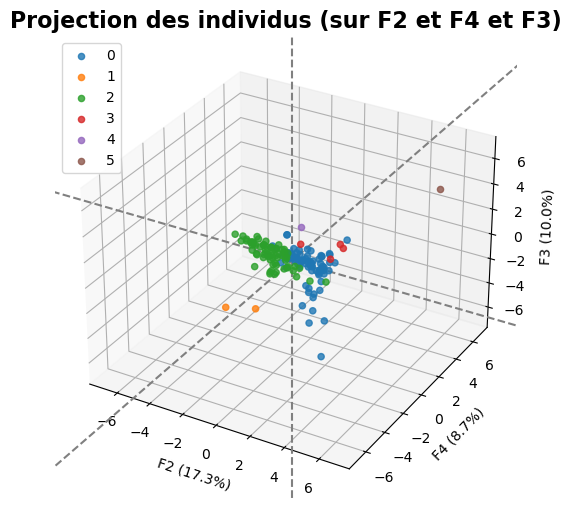

In [79]:
# Définition de la fonction display_factorial_planes pour plotter les plans factoriels
def display_factorial_volume(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1, d2, d3 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(6, 6))
            ax = fig.add_subplot(111, projection='3d')  # Create a 3D axes

            # affichage des points
            if illustrative_var is None:
                ax.scatter(X_projected[:, d1], X_projected[:, d2], X_projected[:, d3], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    ax.scatter(X_projected[selected, d1], X_projected[selected, d2], X_projected[selected, d3], alpha=alpha, label=value)
                ax.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y, z) in enumerate(X_projected[:, [d1, d2, d3]]):
                    ax.text(x, y, z, labels[i], fontsize='10', ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2, d3]])) * 1.1
            ax.set_xlim([-boundary, boundary])
            ax.set_ylim([-boundary, boundary])
            ax.set_zlim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            ax.plot([-100, 100], [0, 0], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-100, 100], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            ax.set_ylabel('F{} ({}%)'.format(d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)))
            ax.set_zlabel('F{} ({}%)'.format(d3 + 1, round(100 * pca.explained_variance_ratio_[d3], 1)))

            plt.title("Projection des individus (sur F{} et F{} et F{})".format(d1 + 1, d2 + 1, d3 + 1), fontsize=16, fontweight='bold')
            plt.show(block=False)

# Example usage:
display_factorial_volume(X_reduced, 6, pca, [(1, 3, 2)], illustrative_var=clustersACH, alpha=0.8)


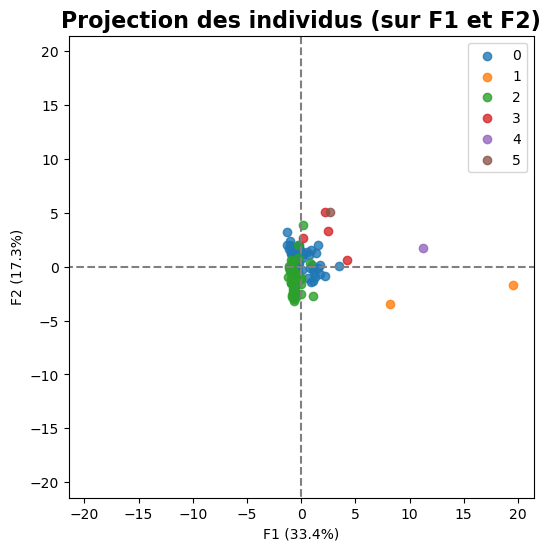

In [80]:
display_factorial_planes(X_reduced, 6, pca, [(0,1)], illustrative_var = clustersACH, alpha = 0.8)

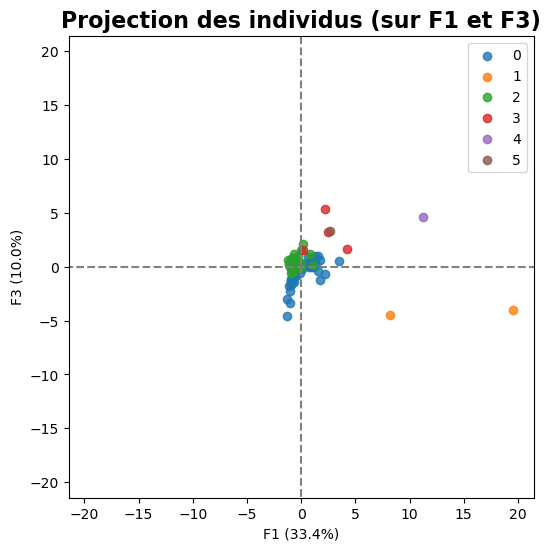

In [81]:
display_factorial_planes(X_reduced, 6, pca, [(0,2)], illustrative_var = clustersACH, alpha = 0.8)

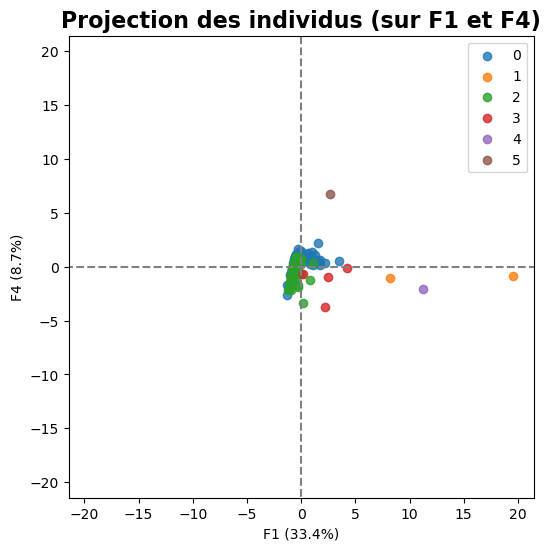

In [82]:
display_factorial_planes(X_reduced, 6, pca, [(0,3)], illustrative_var = clustersACH, alpha = 0.8)

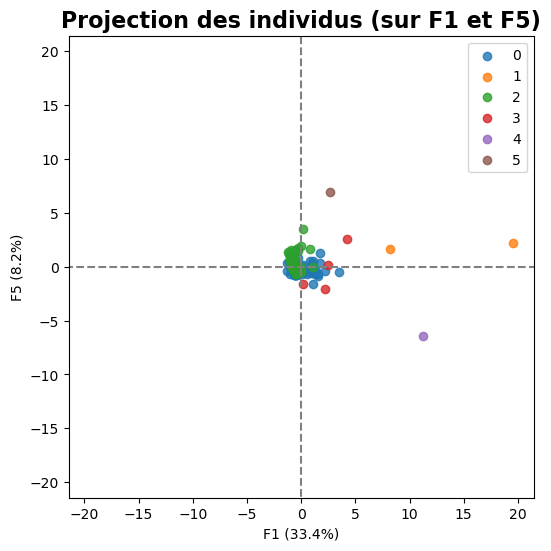

In [83]:
display_factorial_planes(X_reduced, 6, pca, [(0,4)], illustrative_var = clustersACH, alpha = 0.8)

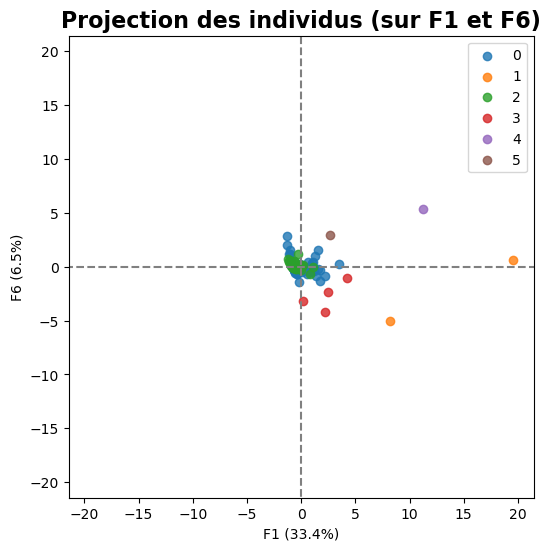

In [84]:
display_factorial_planes(X_reduced, 6, pca, [(0,5)], illustrative_var = clustersACH, alpha = 0.8)

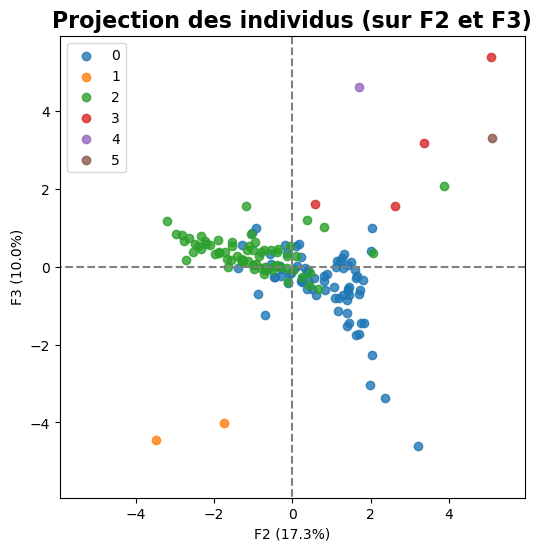

In [85]:
display_factorial_planes(X_reduced, 6, pca, [(1,2)], illustrative_var = clustersACH, alpha = 0.8)

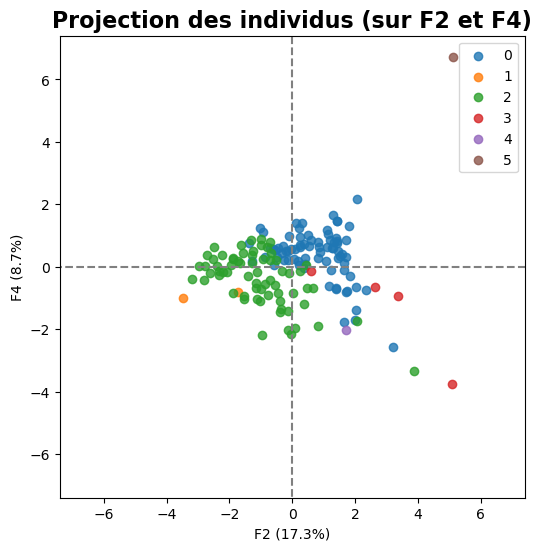

In [86]:
display_factorial_planes(X_reduced, 6, pca, [(1, 3)], illustrative_var = clustersACH, alpha = 0.8)

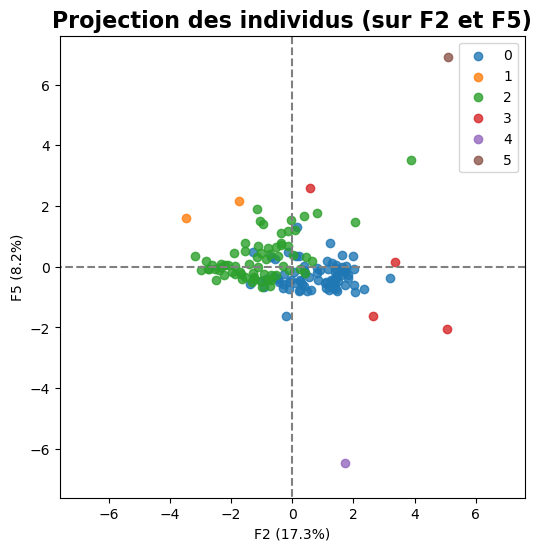

In [87]:
display_factorial_planes(X_reduced, 6, pca, [(1, 4)], illustrative_var = clustersACH, alpha = 0.8)

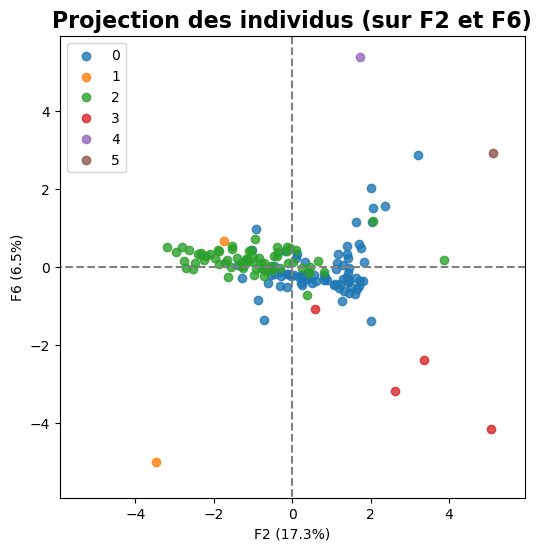

In [88]:
display_factorial_planes(X_reduced, 6, pca, [(1, 5)], illustrative_var = clustersACH, alpha = 0.8)

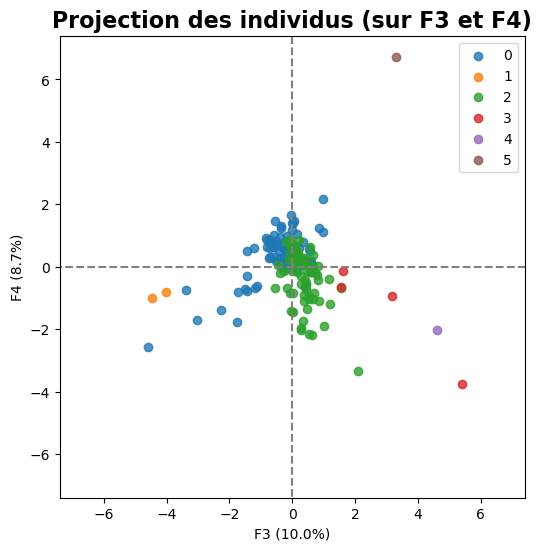

In [89]:
display_factorial_planes(X_reduced, 6, pca, [(2,3)], illustrative_var = clustersACH, alpha = 0.8)

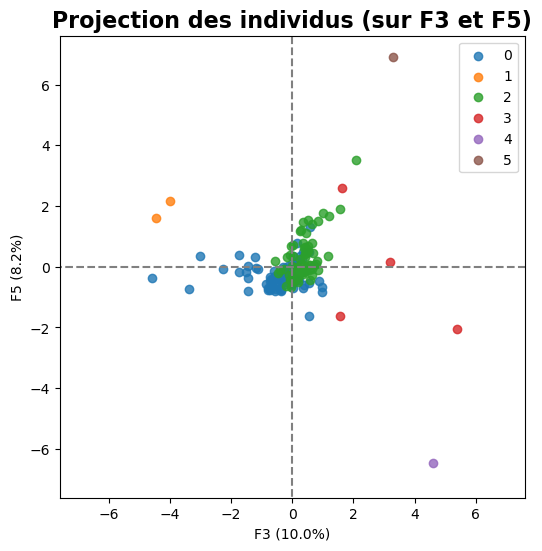

In [90]:
display_factorial_planes(X_reduced, 6, pca, [(2,4)], illustrative_var = clustersACH, alpha = 0.8)

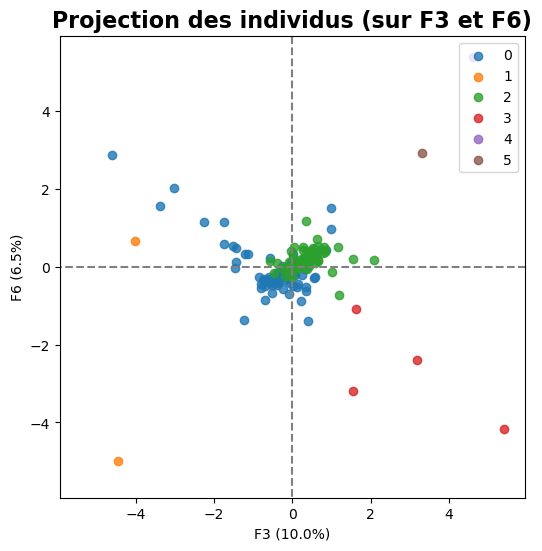

In [91]:
display_factorial_planes(X_reduced, 6, pca, [(2,5)], illustrative_var = clustersACH, alpha = 0.8)

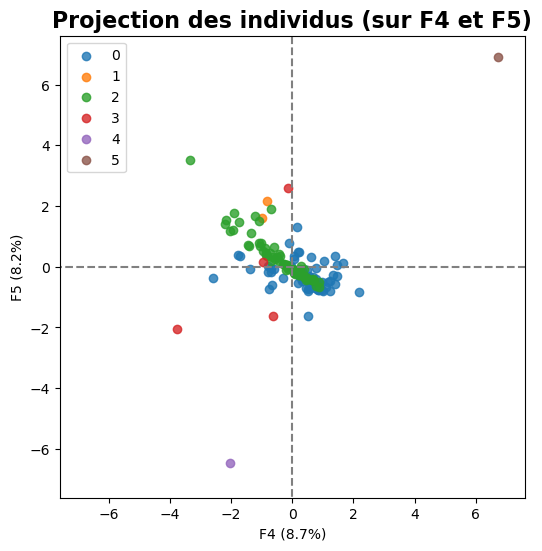

In [92]:
display_factorial_planes(X_reduced, 6, pca, [(3,4)], illustrative_var = clustersACH, alpha = 0.8)

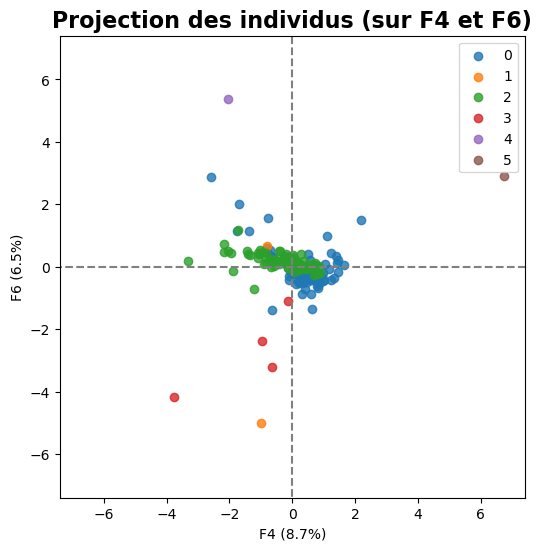

In [93]:
display_factorial_planes(X_reduced, 6, pca, [(3,5)], illustrative_var = clustersACH, alpha = 0.8)

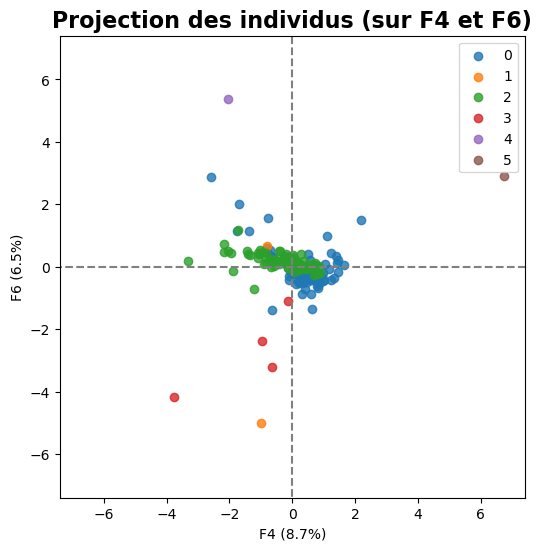

In [94]:
display_factorial_planes(X_reduced, 6, pca, [(3,5)], illustrative_var = clustersACH, alpha = 0.8)

In [95]:
# Ajout des clusters dans df
data2 = data.merge(clusters_name1, on = data.index)
data2.rename(columns={"key_0":"Pays"}, inplace= True)
data2

Pays                       Pays  PIB_Habitant  Disponibilité intérieure  \
0      0                Afghanistan      0.014344                      57.0   
1      1             Afrique du Sud      0.107383                    2118.0   
2      2                    Albanie      1.565167                      47.0   
3      3                    Algérie      0.099294                     277.0   
4      4                  Allemagne      0.540197                    1739.0   
..   ...                        ...           ...                       ...   
147  148                    Vanuatu     10.796008                       3.0   
148  149                   Viet Nam      0.025005                    1206.0   
149  150                     Zambie      0.091071                      60.0   
150  151                   Zimbabwe      0.108747                      76.0   
151  152  Chine, Taiwan Province de           NaN                     785.0   

     Exportations - Quantité  Importations - Quantité  Nourriture  Pertes  \
0                        NaN                     29.0        55.0     2.0   
1                       63.0                    514.0      2035.0    83.0   
2                        0.0                     38.0        47.0     NaN   
3                        0.0                      2.0       264.0    13.0   
4                      646.0                    842.0      1609.0     NaN   
..                       ...                      ...         ...     ...   
147                      NaN                      4.0         3.0     NaN   
148                      1.0                    291.0      1166.0    39.0   
149                      1.0                     12.0        58.0     2.0   
150                      NaN                      6.0        67.0     3.0   
151                      8.0                    161.0       785.0     NaN   

     Production  Variation de stock  ...  Stabilité_pol  Groupe_revenu  DCII  \
0          28.0                 0.0  ...          -2.80            0.0   0.0   
1        1667.0                 0.0  ...          -0.28            2.0   NaN   
2          13.0                 4.0  ...           0.38            2.0   NaN   
3         275.0                 0.0  ...          -0.92            1.0   NaN   
4        1514.0               -29.0  ...           0.59            3.0   NaN   
..          ...                 ...  ...            ...            ...   ...   
147         1.0                 1.0  ...           0.70            1.0   4.0   
148       918.0                 2.0  ...           0.23            1.0   NaN   
149        49.0                 0.0  ...           0.15            1.0   NaN   
150        69.0                 0.0  ...          -0.71            1.0   4.0   
151       652.0                20.0  ...           0.86            2.0   NaN   

           GCF       ICP       ITE           IED  TTCR       PC6  cluster  
0          NaN  4.975952  1.633893  5.153390e+07  71.4  0.500963        4  
1          NaN       NaN       NaN  2.058580e+09   NaN -0.268052        3  
2          NaN       NaN       NaN  1.022758e+09   NaN -0.335929        3  
3          NaN       NaN       NaN  1.230243e+09   NaN -0.000689        4  
4          NaN       NaN       NaN  1.090000e+11   NaN -2.394166        0  
..         ...       ...       ...           ...   ...       ...      ...  
147  27.860974  3.084526  3.705910  3.969442e+07   8.5  0.401470        5  
148        NaN       NaN       NaN  1.410000e+10   NaN -0.521120        3  
149        NaN       NaN       NaN  1.107520e+09   NaN  0.137523        4  
150   9.700147  0.893962  5.416872  3.071877e+08  31.6 -0.026463        4  
151        NaN       NaN       NaN           NaN   NaN -0.211741        3  

[152 rows x 23 columns]

# 5.3. Interpretation des clusters
#### [Retour](#Sommaire:)

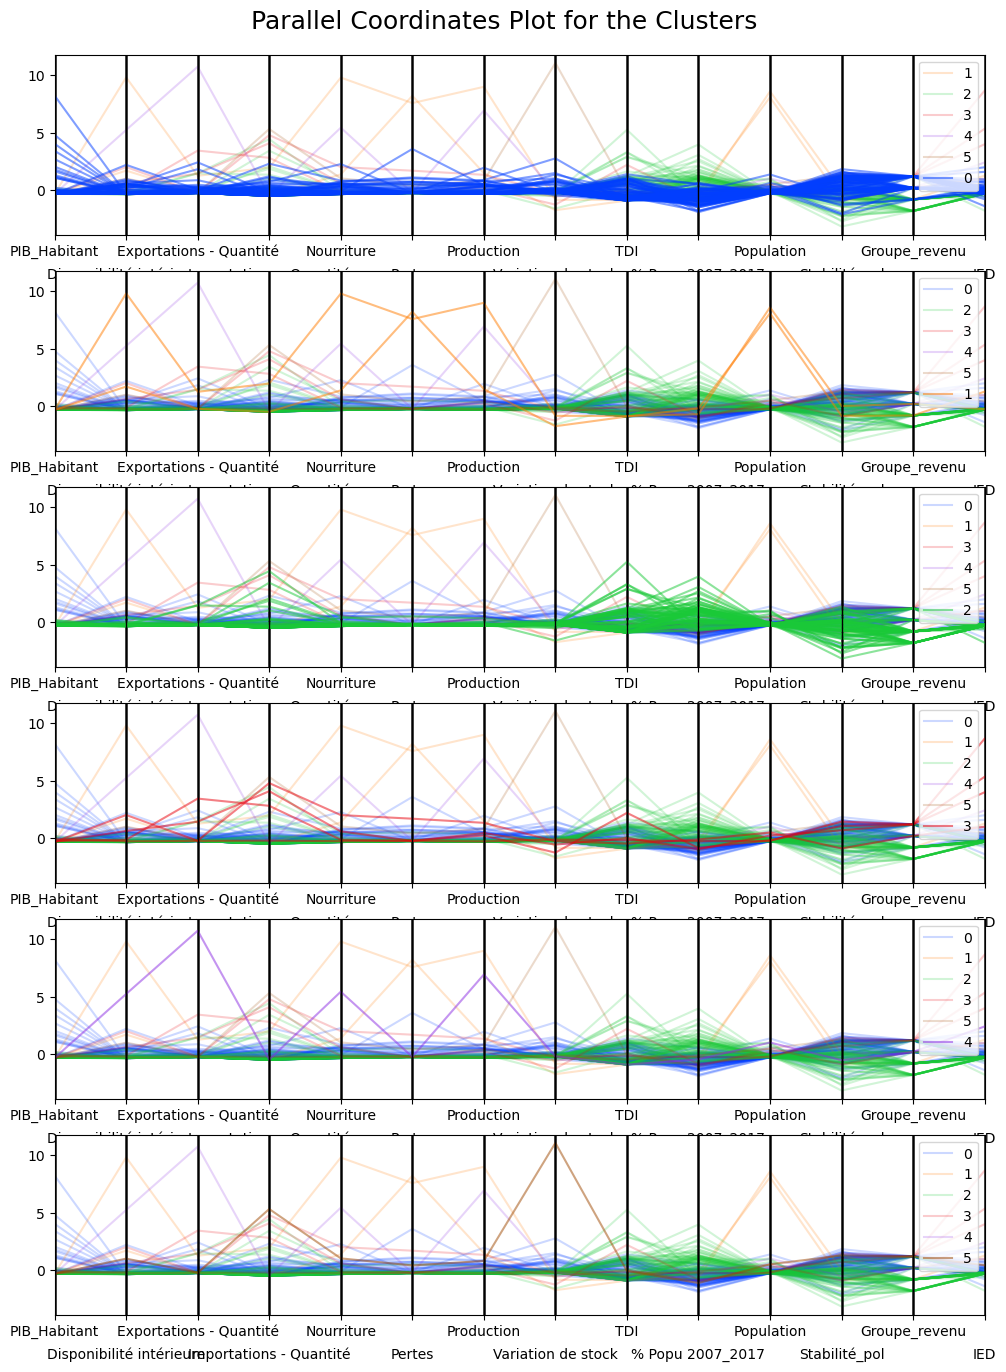

In [96]:
# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered["cluster"] = clustersACH

# Display parallel coordinates plots, one for each cluster
display_parallel_coordinates(X_clustered, 6)

In [97]:
means =  X_clustered.groupby(by="cluster").mean()

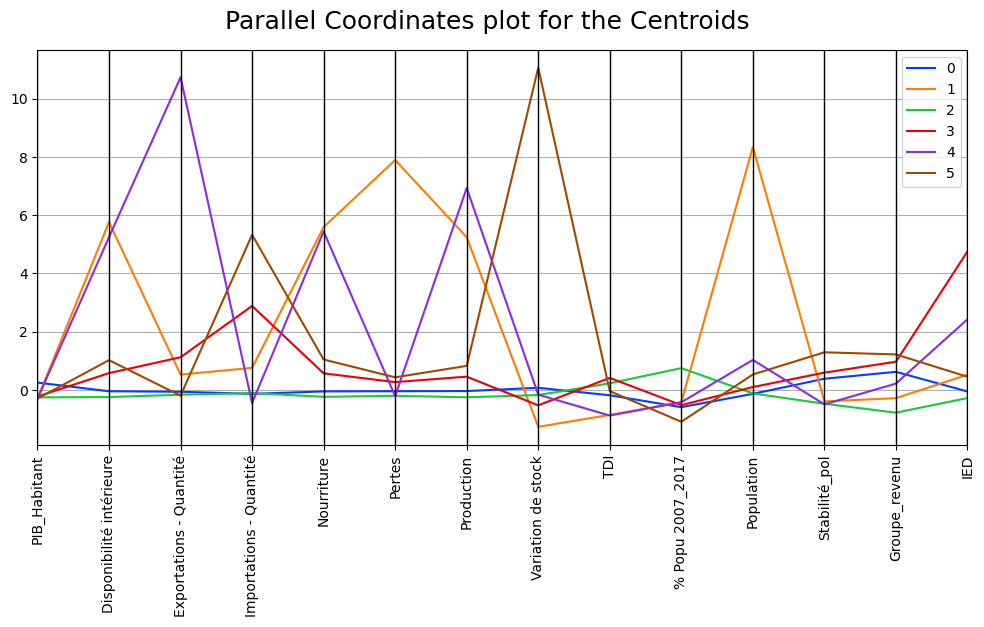

In [98]:
display_parallel_coordinates_centroids(means.reset_index(), 6)

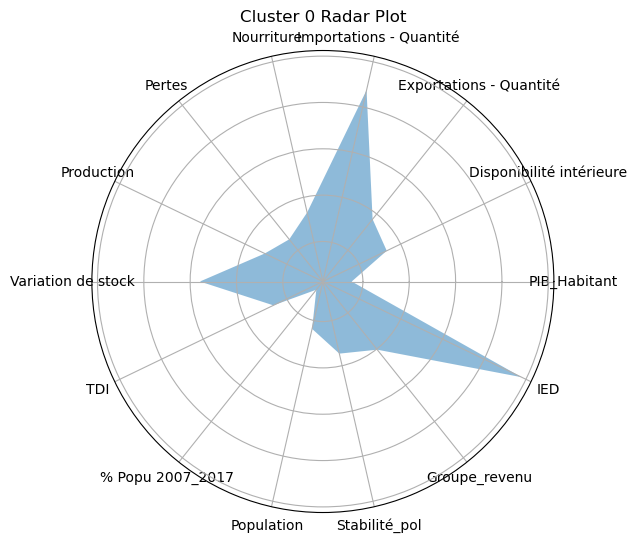

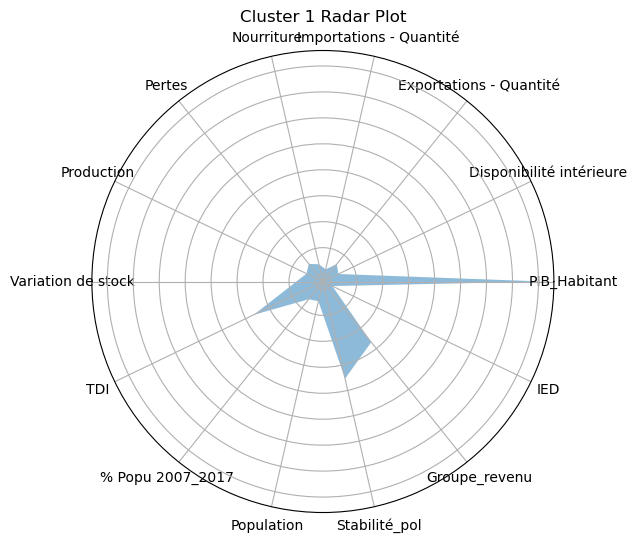

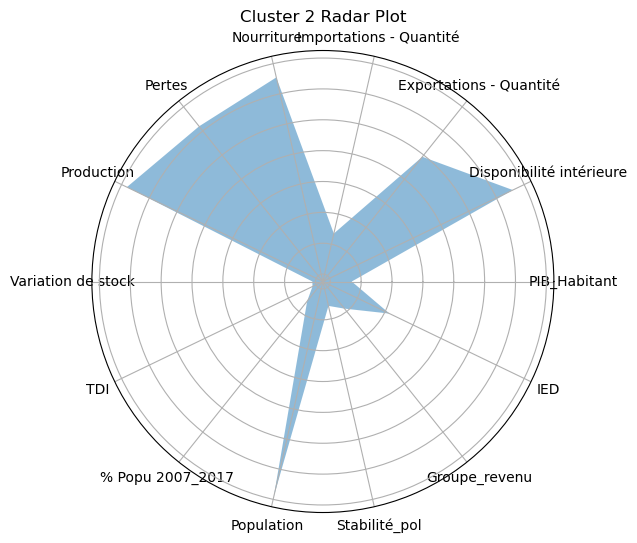

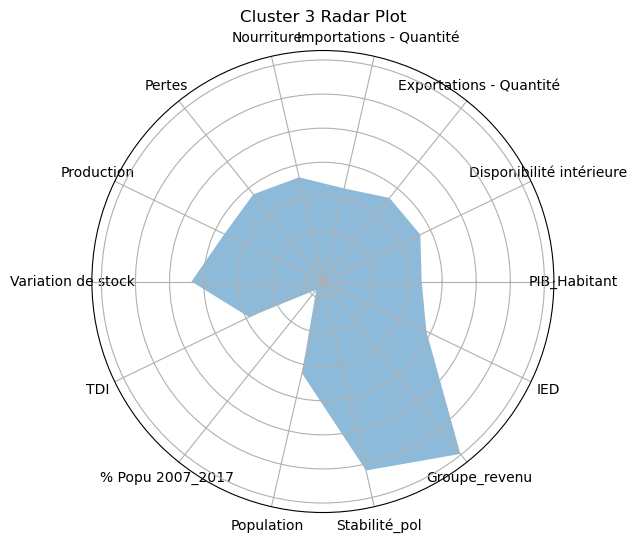

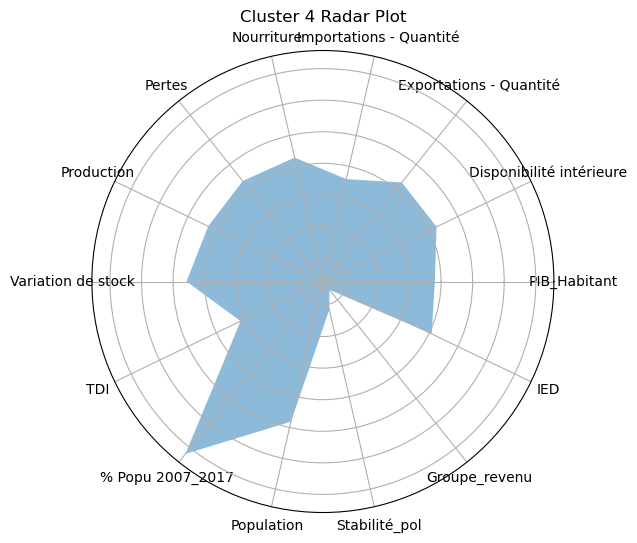

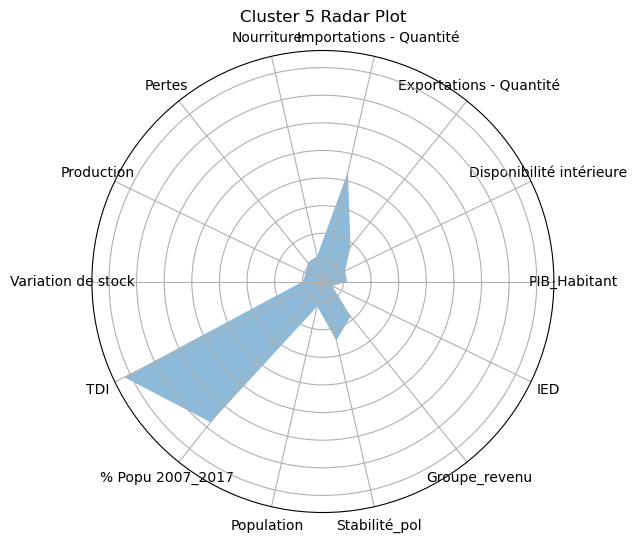

In [100]:

# Fonction pour afficher un graphique en forme de radar pour un cluster donné
def radar_plot_for_cluster(data, cluster_num):
    categories = list(data.columns[:-1])  # Excluez la colonne 'cluster'
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'polar': True})

    values = data.loc[cluster_num].drop('cluster').values.flatten().tolist()
    values += values[:1]

    ax.fill(angles, values, alpha=0.5)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels([])  # Vous pouvez supprimer les étiquettes de l'axe radial si vous le souhaitez
    ax.set_title(f'Cluster {cluster_num} Radar Plot')

    plt.show()

# Utilisez la fonction radar_plot_for_cluster pour afficher les graphiques en forme de radar pour chaque cluster
cluster_count = len(centroids)
for cluster_num in range(cluster_count):
    radar_plot_for_cluster(centroids, cluster_num)

In [101]:
# affichage des différents clusters
liste = data2['cluster'].unique()
for i in liste:
    display(data2.loc[data2['cluster']==i, ['Pays','cluster']])

Pays                                   Pays  cluster
0      0                            Afghanistan        4
3      3                                Algérie        4
14    14                             Bangladesh        4
24    24                           Burkina Faso        4
25    25                               Cambodge        4
34    34                          Côte d'Ivoire        4
38    38                               Djibouti        4
45    45                               Eswatini        4
46    46                               Éthiopie        4
56    57                              Guatemala        4
57    58                                 Guinée        4
58    59                          Guinée-Bissau        4
60    61                                  Haïti        4
61    62                               Honduras        4
73    74                               Jordanie        4
75    76                                  Kenya        4
80    81                                  Liban        4
81    82                                Libéria        4
85    86                             Madagascar        4
87    88                                 Malawi        4
89    90                                   Mali        4
91    92                                  Maroc        4
97    98                             Mozambique        4
98    99                                Myanmar        4
100  101                                  Népal        4
101  102                              Nicaragua        4
102  103                                  Niger        4
103  104                                Nigéria        4
107  108                                Ouganda        4
108  109                            Ouzbékistan        4
109  110                               Pakistan        4
114  115                            Philippines        4
117  118              République centrafricaine        4
118  119  République démocratique populaire lao        4
121  122                                 Rwanda        4
127  128                                Sénégal        4
129  130                           Sierra Leone        4
131  132                                 Soudan        4
132  133                              Sri Lanka        4
136  137                            Tadjikistan        4
137  138                                  Tchad        4
140  141                                   Togo        4
142  143                                Tunisie        4
144  145                                Turquie        4
145  146                                Ukraine        4
149  150                                 Zambie        4
150  151                               Zimbabwe        4

Pays                       Pays  cluster
1      1             Afrique du Sud        3
2      2                    Albanie        3
8      8                  Argentine        3
9      9                    Arménie        3
10    10                  Australie        3
..   ...                        ...      ...
141  142          Trinité-et-Tobago        3
143  144               Turkménistan        3
146  147                    Uruguay        3
148  149                   Viet Nam        3
151  152  Chine, Taiwan Province de        3

[69 rows x 3 columns]

Pays       Pays  cluster
4      4  Allemagne        0
72    73      Japon        0
94    95    Mexique        0
112  113   Pays-Bas        0
134  135     Suisse        0

Pays                     Pays  cluster
5      5                   Angola        5
7      7          Arabie saoudite        5
17    17                 Belgique        5
19    19                    Bénin        5
28    28  Chine, RAS de Hong-Kong        5
41    41      Émirats arabes unis        5
50    51                    Gabon        5
51    52                   Gambie        5
53    54                    Ghana        5
63    64             Îles Salomon        5
66    67                     Iraq        5
77    78                   Koweït        5
88    89                 Maldives        5
93    94               Mauritanie        5
95    96                 Mongolie        5
99   100                  Namibie        5
106  107                     Oman        5
126  127     Sao Tomé-et-Principe        5
139  140              Timor-Leste        5
147  148                  Vanuatu        5

Pays                  Pays  cluster
6      6    Antigua-et-Barbuda        1
13    13               Bahamas        1
29    29   Chine, RAS de Macao        1
39    39             Dominique        1
55    56               Grenade        1
68    69               Islande        1
83    84            Luxembourg        1
123  124  Saint-Kitts-et-Nevis        1

Pays                 Pays  cluster
22   22               Brésil        2
30   30  Chine, continentale        2
64   65                 Inde        2